<a href="https://www.kaggle.com/code/dataranch/alcohol-effects-on-study-feature-importance?scriptVersionId=107433705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Alcohol vs Study Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

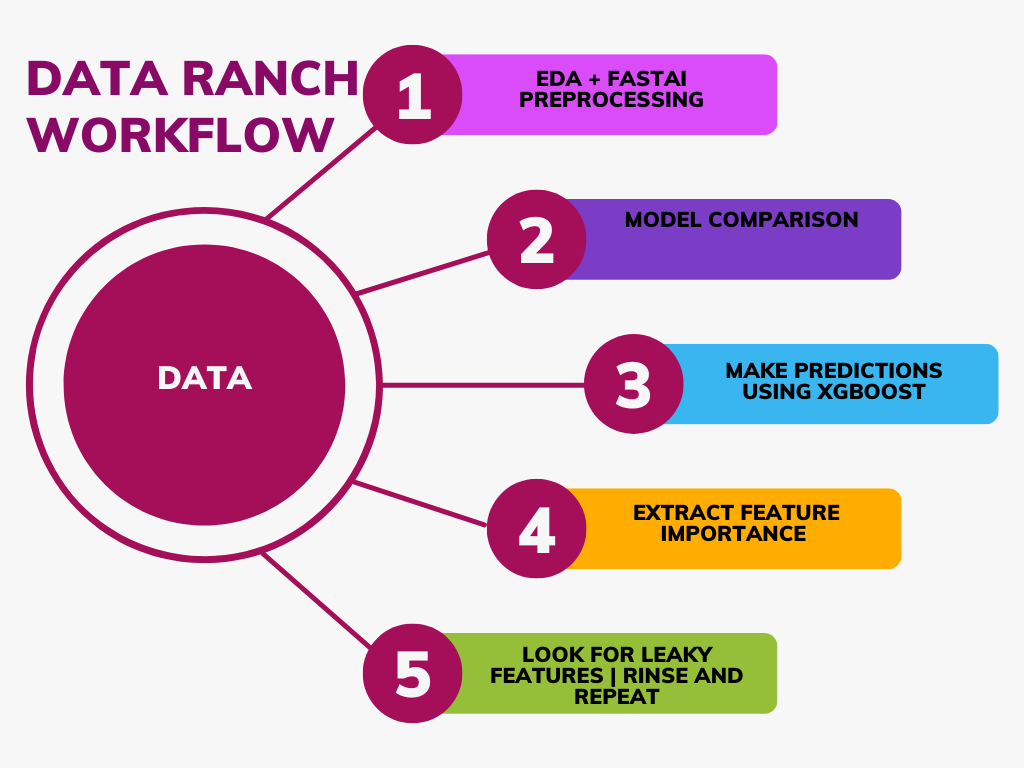

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'alcohol-effects-on-study'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/alcohol-effects-on-study
CSV!
CSV!


In [12]:
df

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
644     MS   F   19       R     GT3       T     2     3  services     other   
645     MS   F   18       U     LE3       T     3     1   teacher  services   
646     MS   F   18       U     GT3       T     1     1     other     other   
647     MS   M   17       U     LE3       T     3     1  services  services   
648     MS   M   18       R     LE3       T     3     2  services     other   

     ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0    ...      4        3      4     1     1      3        4   0  11  11  
1    ...      5        3      3     1     1      3        2   9  11  11  
2    ...      4        3      2     2     3      3        6  12  13  12  
3    ...      3        2      2     1     1      5        0  14  14  14  
4    ...      4        3      2     1     2      5        0  11  13  13  
..   ...    ...      ...    ...   ...   ...    ...      ...  ..  ..  ..  
644  ...      5        4      2     1     2      5        4  10  11  10  
645  ...      4        3      4     1     1      1        4  15  15  16  
646  ...      1        1      1     1     1      5        6  11  12   9  
647  ...      2        4      5     3     4      2        6  10  10  10  
648  ...      4        4      1     3     4      5        4  10  11  11  

[649 rows x 33 columns]

In [13]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [14]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

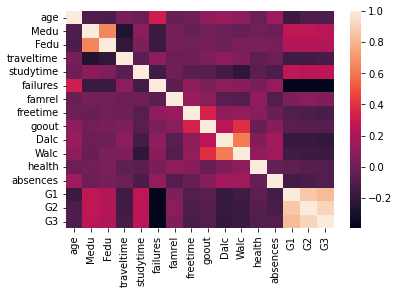

In [15]:
sns.heatmap(df.corr())

In [16]:
df.head().style.background_gradient(cmap = "inferno")

In [17]:
df.describe().T.style.background_gradient(cmap = "viridis")

In [18]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

Target Variable: G3
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  7%|▋         | 3/42 [00:00<00:02, 13.67it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8012156168382149, 'Adjusted R-Squared': 0.7349541557842865, 'RMSE': 1.3436387163171406, 'Time taken': 0.13044047355651855}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8282663067211878, 'Adjusted R-Squared': 0.7710217422949172, 'RMSE': 1.2488754631590053, 'Time taken': 0.04724383354187012}
{'Model': 'BayesianRidge', 'R-Squared': 0.8591551433832849, 'Adjusted R-Squared': 0.81220685784438, 'RMSE': 1.1309980967732838, 'Time taken': 0.05745196342468262}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7029655802135852, 'Adjusted R-Squared': 0.603954106951447, 'RMSE': 1.6424598681869371, 'Time taken': 0.08386993408203125}


 12%|█▏        | 5/42 [00:00<00:02, 15.40it/s]

{'Model': 'DummyRegressor', 'R-Squared': -0.0046317141228877645, 'Adjusted R-Squared': -0.33950895216385035, 'RMSE': 3.0206111418232693, 'Time taken': 0.025045156478881836}
{'Model': 'ElasticNet', 'R-Squared': 0.7614372541459343, 'Adjusted R-Squared': 0.6819163388612458, 'RMSE': 1.4719487548639043, 'Time taken': 0.02393341064453125}


 17%|█▋        | 7/42 [00:00<00:03, 11.20it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.8635948488813892, 'Adjusted R-Squared': 0.8181264651751856, 'RMSE': 1.1130297267888176, 'Time taken': 0.21920466423034668}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.7592996943110089, 'Adjusted R-Squared': 0.6790662590813452, 'RMSE': 1.47852849537231, 'Time taken': 0.026856422424316406}


 26%|██▌       | 11/42 [00:01<00:03,  9.31it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8170308944380483, 'Adjusted R-Squared': 0.7560411925840644, 'RMSE': 1.2890811582511552, 'Time taken': 0.38150739669799805}
{'Model': 'GammaRegressor', 'R-Squared': 0.763957377203738, 'Adjusted R-Squared': 0.6852765029383174, 'RMSE': 1.4641534458530774, 'Time taken': 0.0274045467376709}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8.561775378752692, 'Adjusted R-Squared': -11.749033838336922, 'RMSE': 9.318814069443723, 'Time taken': 0.0887451171875}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8545355682767334, 'Adjusted R-Squared': 0.8060474243689779, 'RMSE': 1.1493962752733167, 'Time taken': 0.1808934211730957}


 38%|███▊      | 16/42 [00:01<00:02,  9.59it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8406949996302742, 'Adjusted R-Squared': 0.7875933328403656, 'RMSE': 1.2028350703028525, 'Time taken': 0.3059501647949219}
{'Model': 'HuberRegressor', 'R-Squared': 0.8646225796179381, 'Adjusted R-Squared': 0.8194967728239175, 'RMSE': 1.1088287943212116, 'Time taken': 0.03326678276062012}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6245758068998373, 'Adjusted R-Squared': 0.4994344091997831, 'RMSE': 1.8465135805351596, 'Time taken': 0.02628302574157715}
{'Model': 'KernelRidge', 'R-Squared': -8.657212827942606, 'Adjusted R-Squared': -11.876283770590142, 'RMSE': 9.365204807497255, 'Time taken': 0.04163479804992676}
{'Model': 'Lars', 'R-Squared': 0.8579051134969147, 'Adjusted R-Squared': 0.8105401513292196, 'RMSE': 1.1360059415488368, 'Time taken': 0.03341388702392578}


 43%|████▎     | 18/42 [00:01<00:02, 10.46it/s]

{'Model': 'LarsCV', 'R-Squared': 0.8633378719200675, 'Adjusted R-Squared': 0.8177838292267567, 'RMSE': 1.1140776652648972, 'Time taken': 0.10790872573852539}
{'Model': 'Lasso', 'R-Squared': 0.7560234932126211, 'Adjusted R-Squared': 0.6746979909501615, 'RMSE': 1.4885567023915567, 'Time taken': 0.041001319885253906}


 52%|█████▏    | 22/42 [00:02<00:01, 11.34it/s]

{'Model': 'LassoCV', 'R-Squared': 0.863302576297944, 'Adjusted R-Squared': 0.8177367683972587, 'RMSE': 1.1142215219655418, 'Time taken': 0.18124723434448242}
{'Model': 'LassoLars', 'R-Squared': -0.0046317141228877645, 'Adjusted R-Squared': -0.33950895216385035, 'RMSE': 3.0206111418232693, 'Time taken': 0.022515058517456055}
{'Model': 'LassoLarsCV', 'R-Squared': 0.8633378719200675, 'Adjusted R-Squared': 0.8177838292267567, 'RMSE': 1.1140776652648972, 'Time taken': 0.08602643013000488}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8589669746009921, 'Adjusted R-Squared': 0.8119559661346563, 'RMSE': 1.1317533515471805, 'Time taken': 0.05493497848510742}


 57%|█████▋    | 24/42 [00:02<00:01, 12.34it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.857905113496915, 'Adjusted R-Squared': 0.8105401513292201, 'RMSE': 1.136005941548835, 'Time taken': 0.06102871894836426}
{'Model': 'LinearSVR', 'R-Squared': 0.8629296759240852, 'Adjusted R-Squared': 0.8172395678987803, 'RMSE': 1.1157402435251367, 'Time taken': 0.0682835578918457}


 67%|██████▋   | 28/42 [00:03<00:02,  5.30it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.7043115731888765, 'Adjusted R-Squared': 0.6057487642518353, 'RMSE': 1.6387342905351692, 'Time taken': 1.2023255825042725}
{'Model': 'NuSVR', 'R-Squared': 0.7716702667658062, 'Adjusted R-Squared': 0.6955603556877417, 'RMSE': 1.4400335575927974, 'Time taken': 0.0744781494140625}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.8547705670381291, 'Adjusted R-Squared': 0.8063607560508389, 'RMSE': 1.1484674713181409, 'Time taken': 0.024695396423339844}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.8528996011728736, 'Adjusted R-Squared': 0.8038661348971647, 'RMSE': 1.1558415522505474, 'Time taken': 0.037683725357055664}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.7868133570693685, 'Adjusted R-Squared': 0.7157511427591581, 'RMSE': 1.3914620736053849, 'Time taken': 0.027084827423095703}


 74%|███████▍  | 31/42 [00:03<00:01,  7.72it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.8280589186627827, 'Adjusted R-Squared': 0.7707452248837103, 'RMSE': 1.2496293155514635, 'Time taken': 0.0379796028137207}
{'Model': 'QuantileRegressor', 'R-Squared': -0.002917940371786054, 'Adjusted R-Squared': -0.3372239204957146, 'RMSE': 3.0180336531907543, 'Time taken': 4.86662483215332}


 79%|███████▊  | 33/42 [00:09<00:07,  1.26it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.8261905575102639, 'Adjusted R-Squared': 0.768254076680352, 'RMSE': 1.2564003866001707, 'Time taken': 0.30341172218322754}


 90%|█████████ | 38/42 [00:09<00:01,  2.41it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8481175096272182, 'Adjusted R-Squared': 0.797490012836291, 'RMSE': 1.1744789377395402, 'Time taken': 0.40486955642700195}
{'Model': 'Ridge', 'R-Squared': 0.8581696429989114, 'Adjusted R-Squared': 0.8108928573318819, 'RMSE': 1.1349480319973095, 'Time taken': 0.016577959060668945}
{'Model': 'RidgeCV', 'R-Squared': 0.858169642998776, 'Adjusted R-Squared': 0.8108928573317014, 'RMSE': 1.134948031997852, 'Time taken': 0.03128457069396973}
{'Model': 'SGDRegressor', 'R-Squared': 0.858023025511821, 'Adjusted R-Squared': 0.8106973673490947, 'RMSE': 1.1355345081552444, 'Time taken': 0.02927231788635254}
{'Model': 'SVR', 'R-Squared': 0.7727854488005791, 'Adjusted R-Squared': 0.6970472650674389, 'RMSE': 1.4365126293915327, 'Time taken': 0.08048272132873535}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.857905113496915, 'Adjusted R-Squared': 0.8105401513292201, 'RMSE': 1.136005941548835, 'Time taken': 0.0231168270111084}
{'Model': 'TweedieRe

100%|██████████| 42/42 [00:11<00:00,  3.69it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8443885127145843, 'Adjusted R-Squared': 0.792518016952779, 'RMSE': 1.1888094, 'Time taken': 1.5524580478668213}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8422216536049295, 'Adjusted R-Squared': 0.7896288714732393, 'RMSE': 1.1970576823070396, 'Time taken': 0.1763474941253662}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: G3
G3
Target Standard Deviation: 2.8933176428191425
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HuberRegressor                               0.82       0.86  1.11        0.03
ElasticNetCV                                 0.82       0.86  1.11        0.22
LassoLarsCV                                  0.82       0.86  1.11        0.09
LarsCV                                       0.82       0.86  1.11        0.11
LassoCV                                      0.82       0.86  1.11        0.18
LinearSVR  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7.652763843536377.
Better model found at epoch 1 with _rmse value: 4.713425159454346.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       8       8.70
1       8       5.73
2       4       3.45
3      11       9.94
4       9       7.66
XGBoost RMSE:  1.1886698


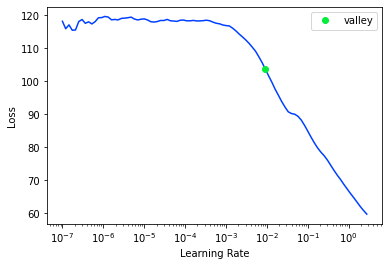

<Figure size 720x720 with 0 Axes>

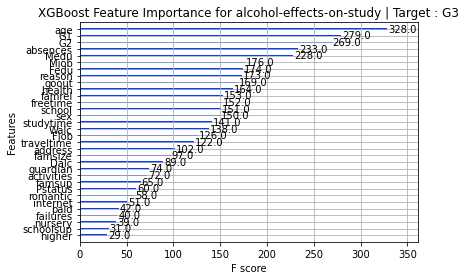

Target Variable: G2
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 16.17it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8981703440372591, 'Adjusted R-Squared': 0.8642271253830123, 'RMSE': 0.9044892020142989, 'Time taken': 0.1289362907409668}
{'Model': 'BaggingRegressor', 'R-Squared': 0.8947208550869896, 'Adjusted R-Squared': 0.8596278067826528, 'RMSE': 0.9196814413090938, 'Time taken': 0.05123615264892578}
{'Model': 'BayesianRidge', 'R-Squared': 0.9163732994972403, 'Adjusted R-Squared': 0.8884977326629871, 'RMSE': 0.8196694132755158, 'Time taken': 0.03434395790100098}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.7867593160500845, 'Adjusted R-Squared': 0.7156790880667794, 'RMSE': 1.308884370207561, 'Time taken': 0.05139803886413574}
{'Model': 'DummyRegressor', 'R-Squared': -9.241385189318052e-06, 'Adjusted R-Squared': -0.3333456551802523, 'RMSE': 2.834446440571204, 'Time taken': 0.020949125289916992}
{'Model': 'ElasticNet', 'R-Squared': 0.7745520489115865, 'Adjusted R-Squared': 0.6994027318821153, 'RMSE': 1.3458274888999984, 'Time taken': 0.0334832668304

 17%|█▋        | 7/42 [00:00<00:02, 14.30it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9200997609688849, 'Adjusted R-Squared': 0.8934663479585132, 'RMSE': 0.8011987952225915, 'Time taken': 0.1703329086303711}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8099166753930618, 'Adjusted R-Squared': 0.7465555671907491, 'RMSE': 1.2357717357771767, 'Time taken': 0.02645254135131836}


 21%|██▏       | 9/42 [00:00<00:03,  8.67it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9009708333956647, 'Adjusted R-Squared': 0.8679611111942197, 'RMSE': 0.8919649939249841, 'Time taken': 0.37618064880371094}
{'Model': 'GammaRegressor', 'R-Squared': 0.8004535905262928, 'Adjusted R-Squared': 0.7339381207017238, 'RMSE': 1.2661588857285995, 'Time taken': 0.021695613861083984}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.186434586514403, 'Adjusted R-Squared': -12.581912782019204, 'RMSE': 9.046432532583212, 'Time taken': 0.07273483276367188}


 29%|██▊       | 12/42 [00:01<00:03,  9.33it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9075795481825518, 'Adjusted R-Squared': 0.8767727309100691, 'RMSE': 0.8616884901053535, 'Time taken': 0.19150161743164062}


 40%|████      | 17/42 [00:01<00:02, 10.99it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8836859878997263, 'Adjusted R-Squared': 0.8449146505329684, 'RMSE': 0.9666789607062787, 'Time taken': 0.2927556037902832}
{'Model': 'HuberRegressor', 'R-Squared': 0.9182445038022597, 'Adjusted R-Squared': 0.8909926717363463, 'RMSE': 0.8104472027893893, 'Time taken': 0.05266237258911133}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.685407273325654, 'Adjusted R-Squared': 0.580543031100872, 'RMSE': 1.5897930244107616, 'Time taken': 0.02608966827392578}
{'Model': 'KernelRidge', 'R-Squared': -8.253967280366949, 'Adjusted R-Squared': -11.338623040489264, 'RMSE': 8.622440935484512, 'Time taken': 0.03488874435424805}
{'Model': 'Lars', 'R-Squared': 0.9165590133662368, 'Adjusted R-Squared': 0.8887453511549824, 'RMSE': 0.8187587676092066, 'Time taken': 0.03360486030578613}


 45%|████▌     | 19/42 [00:01<00:01, 11.72it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9177765137278097, 'Adjusted R-Squared': 0.8903686849704129, 'RMSE': 0.8127634997713394, 'Time taken': 0.10838532447814941}
{'Model': 'Lasso', 'R-Squared': 0.751856537501224, 'Adjusted R-Squared': 0.6691420500016321, 'RMSE': 1.4119446340062023, 'Time taken': 0.024730443954467773}


 50%|█████     | 21/42 [00:02<00:02, 10.31it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9179826458936023, 'Adjusted R-Squared': 0.8906435278581365, 'RMSE': 0.8117440718532257, 'Time taken': 0.19894838333129883}
{'Model': 'LassoLars', 'R-Squared': -9.241385189318052e-06, 'Adjusted R-Squared': -0.3333456551802523, 'RMSE': 2.834446440571204, 'Time taken': 0.048418283462524414}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9177765137278097, 'Adjusted R-Squared': 0.8903686849704129, 'RMSE': 0.8127634997713394, 'Time taken': 0.10235047340393066}


 60%|█████▉    | 25/42 [00:02<00:01, 12.24it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.9183828661311977, 'Adjusted R-Squared': 0.8911771548415969, 'RMSE': 0.8097611152961479, 'Time taken': 0.051630258560180664}
{'Model': 'LinearRegression', 'R-Squared': 0.9165590133662369, 'Adjusted R-Squared': 0.8887453511549825, 'RMSE': 0.8187587676092063, 'Time taken': 0.023657798767089844}
{'Model': 'LinearSVR', 'R-Squared': 0.9158933242080995, 'Adjusted R-Squared': 0.8878577656107994, 'RMSE': 0.8220182932721332, 'Time taken': 0.0791473388671875}


 64%|██████▍   | 27/42 [00:03<00:03,  4.13it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8360564364198317, 'Adjusted R-Squared': 0.781408581893109, 'RMSE': 1.1476604982619636, 'Time taken': 1.1849205493927002}
{'Model': 'NuSVR', 'R-Squared': 0.8208860842473589, 'Adjusted R-Squared': 0.7611814456631452, 'RMSE': 1.1995846849719705, 'Time taken': 0.0746157169342041}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9202989821095745, 'Adjusted R-Squared': 0.8937319761460993, 'RMSE': 0.8001993278900328, 'Time taken': 0.026320695877075195}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.921612854777232, 'Adjusted R-Squared': 0.8954838063696426, 'RMSE': 0.7935762692263341, 'Time taken': 0.03609204292297363}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.8216068238911407, 'Adjusted R-Squared': 0.7621424318548543, 'RMSE': 1.1971687371457194, 'Time taken': 0.028479814529418945}


 74%|███████▍  | 31/42 [00:03<00:01,  6.78it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.8951484214155282, 'Adjusted R-Squared': 0.8601978952207043, 'RMSE': 0.9178120070646398, 'Time taken': 0.036324262619018555}
{'Model': 'QuantileRegressor', 'R-Squared': -0.04787051017851107, 'Adjusted R-Squared': -0.39716068023801476, 'RMSE': 2.901483181138573, 'Time taken': 4.689110279083252}


 79%|███████▊  | 33/42 [00:08<00:06,  1.39it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.8630863153821458, 'Adjusted R-Squared': 0.8174484205095277, 'RMSE': 1.0487927522075429, 'Time taken': 0.2624533176422119}


 88%|████████▊ | 37/42 [00:09<00:02,  2.25it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.8970167142878513, 'Adjusted R-Squared': 0.8626889523838018, 'RMSE': 0.909598258709889, 'Time taken': 0.4221618175506592}
{'Model': 'Ridge', 'R-Squared': 0.9165434944680196, 'Adjusted R-Squared': 0.8887246592906929, 'RMSE': 0.8188349031137677, 'Time taken': 0.017177581787109375}
{'Model': 'RidgeCV', 'R-Squared': 0.9161882361541243, 'Adjusted R-Squared': 0.8882509815388323, 'RMSE': 0.8205758637986701, 'Time taken': 0.04557442665100098}
{'Model': 'SGDRegressor', 'R-Squared': 0.9159145888013827, 'Adjusted R-Squared': 0.8878861184018435, 'RMSE': 0.821914371737323, 'Time taken': 0.06393742561340332}
{'Model': 'SVR', 'R-Squared': 0.8301971558046207, 'Adjusted R-Squared': 0.7735962077394943, 'RMSE': 1.1679889349929269, 'Time taken': 0.06486630439758301}


 95%|█████████▌| 40/42 [00:09<00:00,  3.35it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9165590133662369, 'Adjusted R-Squared': 0.8887453511549825, 'RMSE': 0.8187587676092063, 'Time taken': 0.01989126205444336}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7929647037476337, 'Adjusted R-Squared': 0.7239529383301784, 'RMSE': 1.2896992412941257, 'Time taken': 0.04459118843078613}


100%|██████████| 42/42 [00:10<00:00,  4.08it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8949829789593556, 'Adjusted R-Squared': 0.8599773052791408, 'RMSE': 0.9185358, 'Time taken': 0.8304769992828369}
{'Model': 'LGBMRegressor', 'R-Squared': 0.8786365024988929, 'Adjusted R-Squared': 0.8381820033318572, 'RMSE': 0.987439031682649, 'Time taken': 0.09465169906616211}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: G2
G2
Target Standard Deviation: 2.748261957489178
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                  0.90       0.92  0.79        0.04
OrthogonalMatchingPursuit                    0.89       0.92  0.80        0.03
ElasticNetCV                                 0.89       0.92  0.80        0.17
LassoLarsIC                                  0.89       0.92  0.81        0.05
HuberRegressor                               0.89       0.92  0.81        0.05
LassoCV    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7.1356096267700195.
Better model found at epoch 1 with _rmse value: 6.417510032653809.
Better model found at epoch 2 with _rmse value: 4.065567493438721.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0      11      11.60
1       8       7.51
2      10       9.24
3       1       3.58
4      10       9.17
XGBoost RMSE:  0.91881186


<Figure size 432x288 with 0 Axes>

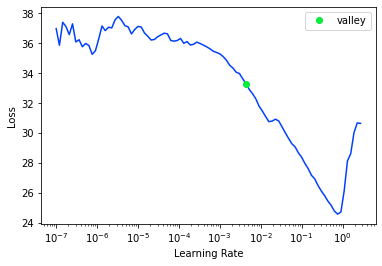

<Figure size 720x720 with 0 Axes>

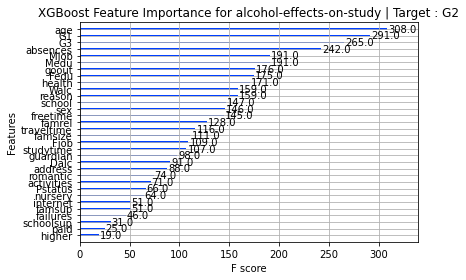

Target Variable: G1
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 15.26it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.8085732637851326, 'Adjusted R-Squared': 0.7447643517135102, 'RMSE': 1.1291713375320818, 'Time taken': 0.1298508644104004}
{'Model': 'BaggingRegressor', 'R-Squared': 0.7783583543846987, 'Adjusted R-Squared': 0.704477805846265, 'RMSE': 1.2150222507293609, 'Time taken': 0.049193382263183594}
{'Model': 'BayesianRidge', 'R-Squared': 0.7771232276262618, 'Adjusted R-Squared': 0.7028309701683492, 'RMSE': 1.2184029817619029, 'Time taken': 0.03479504585266113}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.510023457235655, 'Adjusted R-Squared': 0.3466979429808734, 'RMSE': 1.806534220952614, 'Time taken': 0.06409168243408203}
{'Model': 'DummyRegressor', 'R-Squared': -1.1971551562073302e-05, 'Adjusted R-Squared': -0.3333492954020827, 'RMSE': 2.5808403962311908, 'Time taken': 0.04060721397399902}
{'Model': 'ElasticNet', 'R-Squared': 0.6662818492739379, 'Adjusted R-Squared': 0.5550424656985838, 'RMSE': 1.4908998203403916, 'Time taken': 0.0180246829986

 17%|█▋        | 7/42 [00:00<00:02, 12.44it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.7914534687583696, 'Adjusted R-Squared': 0.7219379583444929, 'RMSE': 1.1785826229620162, 'Time taken': 0.21841049194335938}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.41458859617466615, 'Adjusted R-Squared': 0.21945146156622153, 'RMSE': 1.9746454887400802, 'Time taken': 0.05549454689025879}


 26%|██▌       | 11/42 [00:01<00:03,  9.54it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.766927818477084, 'Adjusted R-Squared': 0.6892370913027788, 'RMSE': 1.2459590496835649, 'Time taken': 0.3829765319824219}
{'Model': 'GammaRegressor', 'R-Squared': 0.7241809904287861, 'Adjusted R-Squared': 0.6322413205717149, 'RMSE': 1.3554098754935728, 'Time taken': 0.02434682846069336}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -13.233665792632625, 'Adjusted R-Squared': -17.9782210568435, 'RMSE': 9.736815268224925, 'Time taken': 0.08392834663391113}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8057221310520695, 'Adjusted R-Squared': 0.7409628414027594, 'RMSE': 1.1375492639337634, 'Time taken': 0.19057440757751465}


 38%|███▊      | 16/42 [00:01<00:02,  9.64it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7608963939512179, 'Adjusted R-Squared': 0.6811951919349573, 'RMSE': 1.2619774982003462, 'Time taken': 0.2865417003631592}
{'Model': 'HuberRegressor', 'R-Squared': 0.7806573621373856, 'Adjusted R-Squared': 0.7075431495165141, 'RMSE': 1.208704333879178, 'Time taken': 0.039910078048706055}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.5508044027426922, 'Adjusted R-Squared': 0.40107253699025625, 'RMSE': 1.7297219384907285, 'Time taken': 0.024588584899902344}
{'Model': 'KernelRidge', 'R-Squared': -12.403824089051113, 'Adjusted R-Squared': -16.87176545206815, 'RMSE': 9.448718446088158, 'Time taken': 0.051317453384399414}
{'Model': 'Lars', 'R-Squared': 0.7783548976512553, 'Adjusted R-Squared': 0.7044731968683404, 'RMSE': 1.215031725464267, 'Time taken': 0.07685422897338867}


 43%|████▎     | 18/42 [00:01<00:02,  8.90it/s]

{'Model': 'LarsCV', 'R-Squared': 0.7981646286910846, 'Adjusted R-Squared': 0.7308861715881129, 'RMSE': 1.1594637820976925, 'Time taken': 0.1881239414215088}
{'Model': 'Lasso', 'R-Squared': 0.6456190753690878, 'Adjusted R-Squared': 0.5274921004921171, 'RMSE': 1.5363625654321993, 'Time taken': 0.043015241622924805}


 52%|█████▏    | 22/42 [00:02<00:02,  9.63it/s]

{'Model': 'LassoCV', 'R-Squared': 0.798153808625217, 'Adjusted R-Squared': 0.7308717448336227, 'RMSE': 1.159494860164636, 'Time taken': 0.20483016967773438}
{'Model': 'LassoLars', 'R-Squared': -1.1971551562073302e-05, 'Adjusted R-Squared': -0.3333492954020827, 'RMSE': 2.5808403962311908, 'Time taken': 0.03603768348693848}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7981646286910846, 'Adjusted R-Squared': 0.7308861715881129, 'RMSE': 1.1594637820976925, 'Time taken': 0.10262298583984375}
{'Model': 'LassoLarsIC', 'R-Squared': 0.788615338041911, 'Adjusted R-Squared': 0.7181537840558814, 'RMSE': 1.18657524647281, 'Time taken': 0.04498767852783203}


 60%|█████▉    | 25/42 [00:02<00:01, 12.51it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.778354897651255, 'Adjusted R-Squared': 0.70447319686834, 'RMSE': 1.215031725464268, 'Time taken': 0.039431095123291016}
{'Model': 'LinearSVR', 'R-Squared': 0.777221585389811, 'Adjusted R-Squared': 0.7029621138530814, 'RMSE': 1.2181341053428578, 'Time taken': 0.034738779067993164}


 74%|███████▍  | 31/42 [00:04<00:02,  5.38it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.597949113808316, 'Adjusted R-Squared': 0.46393215174442126, 'RMSE': 1.6364361323561356, 'Time taken': 1.7592554092407227}
{'Model': 'NuSVR', 'R-Squared': 0.7013815993995685, 'Adjusted R-Squared': 0.601842132532758, 'RMSE': 1.410317291761968, 'Time taken': 0.0699009895324707}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7917973639259109, 'Adjusted R-Squared': 0.7223964852345479, 'RMSE': 1.177610475178974, 'Time taken': 0.02481222152709961}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7959088015293435, 'Adjusted R-Squared': 0.7278784020391247, 'RMSE': 1.1659251922410216, 'Time taken': 0.037213802337646484}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.4853262442972601, 'Adjusted R-Squared': 0.31376832572968016, 'RMSE': 1.8515035959719286, 'Time taken': 0.02606344223022461}
{'Model': 'PoissonRegressor', 'R-Squared': 0.784031392898318, 'Adjusted R-Squared': 0.7120418571977574, 'RMSE': 1.1993718788352454, 'Time taken': 0.

 79%|███████▊  | 33/42 [00:09<00:06,  1.36it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.6602102075773428, 'Adjusted R-Squared': 0.5469469434364571, 'RMSE': 1.504401342582147, 'Time taken': 0.28374743461608887}


 90%|█████████ | 38/42 [00:10<00:01,  2.42it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7849888659328762, 'Adjusted R-Squared': 0.7133184879105017, 'RMSE': 1.1967102840186379, 'Time taken': 0.4280509948730469}
{'Model': 'Ridge', 'R-Squared': 0.7782726906152614, 'Adjusted R-Squared': 0.7043635874870152, 'RMSE': 1.2152570291046745, 'Time taken': 0.020779132843017578}
{'Model': 'RidgeCV', 'R-Squared': 0.7775085007287121, 'Adjusted R-Squared': 0.7033446676382828, 'RMSE': 1.2173494378446381, 'Time taken': 0.03883790969848633}
{'Model': 'SGDRegressor', 'R-Squared': 0.7768707297236409, 'Adjusted R-Squared': 0.7024943062981879, 'RMSE': 1.2190929529748777, 'Time taken': 0.02560257911682129}
{'Model': 'SVR', 'R-Squared': 0.704537084810621, 'Adjusted R-Squared': 0.6060494464141615, 'RMSE': 1.4028461270395682, 'Time taken': 0.09354829788208008}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.778354897651255, 'Adjusted R-Squared': 0.70447319686834, 'RMSE': 1.215031725464268, 'Time taken': 0.019602060317993164}
{'Model': 'Tweedie

100%|██████████| 42/42 [00:10<00:00,  3.87it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.743151378152449, 'Adjusted R-Squared': 0.6575351708699321, 'RMSE': 1.3079681, 'Time taken': 0.5798861980438232}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7623608271991417, 'Adjusted R-Squared': 0.6831477695988556, 'RMSE': 1.2581069580112154, 'Time taken': 0.0863800048828125}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: G1
G1
Target Standard Deviation: 2.761339584653642
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
AdaBoostRegressor                            0.74       0.81  1.13        0.13
GradientBoostingRegressor                    0.74       0.81  1.14        0.19
LarsCV                                       0.73       0.80  1.16        0.19
LassoLarsCV                                  0.73       0.80  1.16        0.10
LassoCV                                      0.73       0.80  1.16        0.20
OrthogonalMa

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 7.545351982116699.
Better model found at epoch 1 with _rmse value: 6.104948997497559.
Better model found at epoch 2 with _rmse value: 5.630159378051758.
Better model found at epoch 3 with _rmse value: 5.293859958648682.
Better model found at epoch 4 with _rmse value: 4.649385452270508.
Better model found at epoch 5 with _rmse value: 3.7637746334075928.
No improvement since epoch 5: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       8       8.40
1       6       7.27
2      12      11.61
3       9      10.37
4      12      11.98
XGBoost RMSE:  1.3080503


<Figure size 432x288 with 0 Axes>

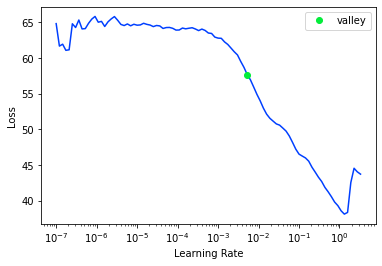

<Figure size 720x720 with 0 Axes>

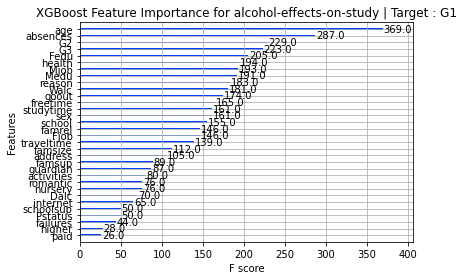

Target Variable: absences
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.22295652950438383, 'Adjusted R-Squared': -0.630608706005845, 'RMSE': 3.9987043748577573, 'Time taken': 0.04626297950744629}


 10%|▉         | 4/42 [00:00<00:02, 17.78it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.081968571612417, 'Adjusted R-Squared': -0.44262476214988933, 'RMSE': 3.7611539545420687, 'Time taken': 0.05564475059509277}
{'Model': 'BayesianRidge', 'R-Squared': 0.0513451476017176, 'Adjusted R-Squared': -0.26487313653104305, 'RMSE': 3.52182607037912, 'Time taken': 0.05340123176574707}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.838813461167235, 'Adjusted R-Squared': -2.7850846148896466, 'RMSE': 6.092313113240934, 'Time taken': 0.06519031524658203}
{'Model': 'DummyRegressor', 'R-Squared': -0.035690559327757665, 'Adjusted R-Squared': -0.3809207457703434, 'RMSE': 3.6798388190872875, 'Time taken': 0.03121042251586914}
{'Model': 'ElasticNet', 'R-Squared': -0.009178395521835414, 'Adjusted R-Squared': -0.34557119402911374, 'RMSE': 3.632434234018746, 'Time taken': 0.018057584762573242}


 17%|█▋        | 7/42 [00:00<00:02, 12.93it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.03324726815052048, 'Adjusted R-Squared': -0.28900364246597254, 'RMSE': 3.5552610240919353, 'Time taken': 0.22923731803894043}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.2245672736632138, 'Adjusted R-Squared': -1.9660896982176181, 'RMSE': 5.393076238829695, 'Time taken': 0.028925180435180664}


 21%|██▏       | 9/42 [00:00<00:04,  7.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.0983387068307795, 'Adjusted R-Squared': -0.464451609107706, 'RMSE': 3.7895001818059035, 'Time taken': 0.4195268154144287}
{'Model': 'GammaRegressor', 'R-Squared': 0.06783117395278515, 'Adjusted R-Squared': -0.24289176806295298, 'RMSE': 3.491090242971964, 'Time taken': 0.02340531349182129}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -1.1844414439223203, 'Adjusted R-Squared': -1.912588591896427, 'RMSE': 5.344215859567605, 'Time taken': 0.06918144226074219}


 29%|██▊       | 12/42 [00:01<00:03,  8.73it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.00511298077629041, 'Adjusted R-Squared': -0.3401506410350539, 'RMSE': 3.6251103286801762, 'Time taken': 0.19007349014282227}


 33%|███▎      | 14/42 [00:01<00:03,  7.49it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.1787753048873657, 'Adjusted R-Squared': -0.5717004065164875, 'RMSE': 3.9258102284109513, 'Time taken': 0.3016664981842041}
{'Model': 'HuberRegressor', 'R-Squared': 0.041698556067586434, 'Adjusted R-Squared': -0.27773525857655135, 'RMSE': 3.539686985174918, 'Time taken': 0.056432485580444336}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.25782915238033977, 'Adjusted R-Squared': -0.6771055365071197, 'RMSE': 4.055315202958808, 'Time taken': 0.026889324188232422}
{'Model': 'KernelRidge', 'R-Squared': -1.2736432869828556, 'Adjusted R-Squared': -2.0315243826438074, 'RMSE': 5.452239844970522, 'Time taken': 0.05923771858215332}


 45%|████▌     | 19/42 [00:01<00:02,  9.97it/s]

{'Model': 'Lars', 'R-Squared': -0.032634936716342766, 'Adjusted R-Squared': -0.376846582288457, 'RMSE': 3.67440645110607, 'Time taken': 0.09664535522460938}
{'Model': 'LarsCV', 'R-Squared': 0.026918106212188486, 'Adjusted R-Squared': -0.29744252505041535, 'RMSE': 3.5668798761519485, 'Time taken': 0.12183761596679688}
{'Model': 'Lasso', 'R-Squared': -0.035690559327757665, 'Adjusted R-Squared': -0.3809207457703434, 'RMSE': 3.6798388190872875, 'Time taken': 0.037749290466308594}


 52%|█████▏    | 22/42 [00:02<00:02,  8.55it/s]

{'Model': 'LassoCV', 'R-Squared': 0.025994932916228786, 'Adjusted R-Squared': -0.2986734227783616, 'RMSE': 3.5685714437644247, 'Time taken': 0.23841166496276855}
{'Model': 'LassoLars', 'R-Squared': -0.035690559327757665, 'Adjusted R-Squared': -0.3809207457703434, 'RMSE': 3.6798388190872875, 'Time taken': 0.0499420166015625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.026918106212188486, 'Adjusted R-Squared': -0.29744252505041535, 'RMSE': 3.5668798761519485, 'Time taken': 0.12239432334899902}


 57%|█████▋    | 24/42 [00:02<00:01, 10.18it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.023789364975603244, 'Adjusted R-Squared': -0.30161418003252893, 'RMSE': 3.572609552185479, 'Time taken': 0.062415122985839844}
{'Model': 'LinearRegression', 'R-Squared': -0.0326349367163421, 'Adjusted R-Squared': -0.37684658228845613, 'RMSE': 3.674406451106069, 'Time taken': 0.04654216766357422}
{'Model': 'LinearSVR', 'R-Squared': 0.028642217452185315, 'Adjusted R-Squared': -0.29514371006375284, 'RMSE': 3.5637185676549774, 'Time taken': 0.06536507606506348}


 67%|██████▋   | 28/42 [00:03<00:02,  4.81it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.12367342363757561, 'Adjusted R-Squared': -0.4982312315167674, 'RMSE': 3.8329560757959307, 'Time taken': 1.2697768211364746}
{'Model': 'NuSVR', 'R-Squared': 0.06624918712049299, 'Adjusted R-Squared': -0.2450010838393426, 'RMSE': 3.494051357638732, 'Time taken': 0.07061171531677246}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.015344704670961828, 'Adjusted R-Squared': -0.35379293956128244, 'RMSE': 3.6435148325429703, 'Time taken': 0.02528214454650879}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.004626489837006753, 'Adjusted R-Squared': -0.33950198644934226, 'RMSE': 3.6242329164812914, 'Time taken': 0.039147138595581055}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.7164999181109244, 'Adjusted R-Squared': -2.621999890814566, 'RMSE': 5.95962091885789, 'Time taken': 0.02572154998779297}


 74%|███████▍  | 31/42 [00:04<00:01,  7.16it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.04835024912794128, 'Adjusted R-Squared': -0.2688663344960782, 'RMSE': 3.5273808830705233, 'Time taken': 0.03859996795654297}
{'Model': 'QuantileRegressor', 'R-Squared': -0.06840890914775466, 'Adjusted R-Squared': -0.42454521219700614, 'RMSE': 3.7375115047310192, 'Time taken': 4.757687091827393}


 79%|███████▊  | 33/42 [00:09<00:07,  1.25it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.550327555532982, 'Adjusted R-Squared': -2.4004367407106426, 'RMSE': 5.774465213744845, 'Time taken': 0.2942032814025879}


 88%|████████▊ | 37/42 [00:09<00:02,  2.13it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.06579356632685884, 'Adjusted R-Squared': -0.2456085782308548, 'RMSE': 3.4949037094009467, 'Time taken': 0.43798184394836426}
{'Model': 'Ridge', 'R-Squared': -0.030510452745482253, 'Adjusted R-Squared': -0.37401393699397634, 'RMSE': 3.6706247483562424, 'Time taken': 0.016979217529296875}
{'Model': 'RidgeCV', 'R-Squared': -0.01549101938049846, 'Adjusted R-Squared': -0.35398802584066447, 'RMSE': 3.6437773446770083, 'Time taken': 0.04332900047302246}
{'Model': 'SGDRegressor', 'R-Squared': -0.014229014019183861, 'Adjusted R-Squared': -0.35230535202557833, 'RMSE': 3.641512481652342, 'Time taken': 0.06155228614807129}
{'Model': 'SVR', 'R-Squared': 0.06832594601605024, 'Adjusted R-Squared': -0.24223207197859953, 'RMSE': 3.490163627998198, 'Time taken': 0.06244039535522461}


 95%|█████████▌| 40/42 [00:09<00:00,  3.25it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.0326349367163421, 'Adjusted R-Squared': -0.37684658228845613, 'RMSE': 3.674406451106069, 'Time taken': 0.02327251434326172}
{'Model': 'TweedieRegressor', 'R-Squared': 0.05978927697986647, 'Adjusted R-Squared': -0.25361429736017804, 'RMSE': 3.5061168646302074, 'Time taken': 0.04303431510925293}


100%|██████████| 42/42 [00:10<00:00,  4.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.3056904872857391, 'Adjusted R-Squared': -0.7409206497143188, 'RMSE': 4.131749, 'Time taken': 0.5724103450775146}
{'Model': 'LGBMRegressor', 'R-Squared': -0.1735026267531412, 'Adjusted R-Squared': -0.5646701690041882, 'RMSE': 3.9170202864671446, 'Time taken': 0.09431934356689453}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: absences
absences
Target Standard Deviation: 4.322429718183866
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
SVR                                         -0.24       0.07  3.49        0.06
GammaRegressor                              -0.24       0.07  3.49        0.02
NuSVR                                       -0.25       0.07  3.49        0.07
RandomForestRegressor                       -0.25       0.07  3.49        0.44
TweedieRegressor                            -0.25       0.06  3.51        

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 4.412137985229492.
Better model found at epoch 1 with _rmse value: 4.380825042724609.
Better model found at epoch 2 with _rmse value: 3.9276492595672607.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       5.91
1       3       4.00
2       1      10.35
3       3       4.77
4       3       2.09
XGBoost RMSE:  4.131946


<Figure size 432x288 with 0 Axes>

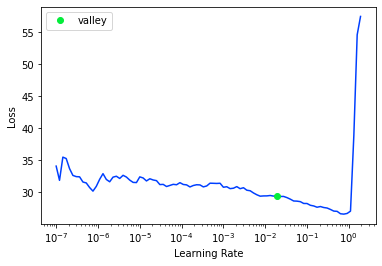

<Figure size 720x720 with 0 Axes>

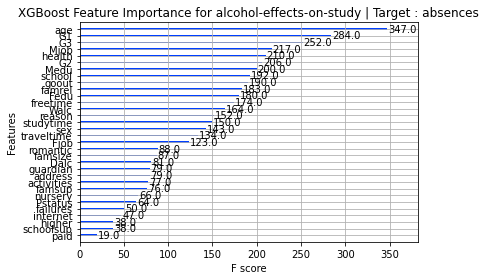

Target Variable: health
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.002050395441903774, 'Adjusted R-Squared': -0.33606719392253837, 'RMSE': 1.5308418571647489, 'Time taken': 0.04355263710021973}


 14%|█▍        | 6/42 [00:00<00:01, 25.31it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.10766046559432674, 'Adjusted R-Squared': -0.47688062079243565, 'RMSE': 1.6094921920528444, 'Time taken': 0.05198097229003906}
{'Model': 'BayesianRidge', 'R-Squared': 0.014954066518241937, 'Adjusted R-Squared': -0.31339457797567727, 'RMSE': 1.5177973414985835, 'Time taken': 0.04062461853027344}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.8893571098206488, 'Adjusted R-Squared': -1.5191428130941982, 'RMSE': 2.102047728088682, 'Time taken': 0.05857586860656738}
{'Model': 'DummyRegressor', 'R-Squared': -0.0005868074043409166, 'Adjusted R-Squared': -0.33411574320578774, 'RMSE': 1.5297234800050163, 'Time taken': 0.02075958251953125}
{'Model': 'ElasticNet', 'R-Squared': -0.0005868074043409166, 'Adjusted R-Squared': -0.33411574320578774, 'RMSE': 1.5297234800050163, 'Time taken': 0.022275209426879883}
{'Model': 'ElasticNetCV', 'R-Squared': 0.007147169400464004, 'Adjusted R-Squared': -0.32380377413271466, 'RMSE': 1.523800057837449, 'Time taken'

 26%|██▌       | 11/42 [00:00<00:02, 10.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.15473296932010916, 'Adjusted R-Squared': -0.5396439590934787, 'RMSE': 1.6433358491733498, 'Time taken': 0.3849012851715088}
{'Model': 'GammaRegressor', 'R-Squared': 0.011942132582731801, 'Adjusted R-Squared': -0.3174104898896908, 'RMSE': 1.5201160232837658, 'Time taken': 0.03447270393371582}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5.353315560412262, 'Adjusted R-Squared': -7.471087413883016, 'RMSE': 3.8546571841213573, 'Time taken': 0.06700825691223145}
{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.015109763122216346, 'Adjusted R-Squared': -0.35347968416295505, 'RMSE': 1.5407850252882194, 'Time taken': 0.17803263664245605}


 38%|███▊      | 16/42 [00:01<00:02, 10.11it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.13186588879176364, 'Adjusted R-Squared': -0.509154518389018, 'RMSE': 1.626983064876737, 'Time taken': 0.2839338779449463}
{'Model': 'HuberRegressor', 'R-Squared': -0.0602259043047666, 'Adjusted R-Squared': -0.41363453907302206, 'RMSE': 1.5746525909000681, 'Time taken': 0.05866599082946777}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.015214553676961895, 'Adjusted R-Squared': -0.3536194049026158, 'RMSE': 1.5408645514422976, 'Time taken': 0.031026601791381836}
{'Model': 'KernelRidge', 'R-Squared': -5.400726623807978, 'Adjusted R-Squared': -7.534302165077303, 'RMSE': 3.869012973260481, 'Time taken': 0.03442072868347168}
{'Model': 'Lars', 'R-Squared': -0.026064885406400062, 'Adjusted R-Squared': -0.3680865138752001, 'RMSE': 1.5490768337081742, 'Time taken': 0.0357058048248291}


 43%|████▎     | 18/42 [00:01<00:02, 10.92it/s]

{'Model': 'LarsCV', 'R-Squared': 0.004872577624743468, 'Adjusted R-Squared': -0.3268365631670087, 'RMSE': 1.5255445460981116, 'Time taken': 0.1052241325378418}
{'Model': 'Lasso', 'R-Squared': -0.0005868074043409166, 'Adjusted R-Squared': -0.33411574320578774, 'RMSE': 1.5297234800050163, 'Time taken': 0.03851771354675293}


 52%|█████▏    | 22/42 [00:02<00:01, 10.57it/s]

{'Model': 'LassoCV', 'R-Squared': 0.005284591338718614, 'Adjusted R-Squared': -0.32628721154837503, 'RMSE': 1.5252287019494455, 'Time taken': 0.22405242919921875}
{'Model': 'LassoLars', 'R-Squared': -0.0005868074043409166, 'Adjusted R-Squared': -0.33411574320578774, 'RMSE': 1.5297234800050163, 'Time taken': 0.044915199279785156}
{'Model': 'LassoLarsCV', 'R-Squared': 0.004872577624743468, 'Adjusted R-Squared': -0.3268365631670087, 'RMSE': 1.5255445460981116, 'Time taken': 0.09646058082580566}
{'Model': 'LassoLarsIC', 'R-Squared': 0.0050498796401095, 'Adjusted R-Squared': -0.32660016047985385, 'RMSE': 1.5254086367836328, 'Time taken': 0.0489354133605957}


 60%|█████▉    | 25/42 [00:02<00:01, 13.26it/s]

{'Model': 'LinearRegression', 'R-Squared': -0.02606488540639984, 'Adjusted R-Squared': -0.36808651387519964, 'RMSE': 1.5490768337081742, 'Time taken': 0.03803896903991699}
{'Model': 'LinearSVR', 'R-Squared': -0.14271893392706803, 'Adjusted R-Squared': -0.5236252452360906, 'RMSE': 1.6347647262000304, 'Time taken': 0.0419008731842041}


 64%|██████▍   | 27/42 [00:03<00:03,  4.26it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2148978027670585, 'Adjusted R-Squared': -0.6198637370227447, 'RMSE': 1.6856034825248092, 'Time taken': 1.2676715850830078}
{'Model': 'NuSVR', 'R-Squared': 0.022626708151287755, 'Adjusted R-Squared': -0.30316438913161625, 'RMSE': 1.5118746324621912, 'Time taken': 0.07609963417053223}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': -0.0019788553370152506, 'Adjusted R-Squared': -0.33597180711602026, 'RMSE': 1.5307872099422657, 'Time taken': 0.026544570922851562}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.0019788553370152506, 'Adjusted R-Squared': -0.33597180711602026, 'RMSE': 1.5307872099422657, 'Time taken': 0.03730511665344238}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.45784477309568516, 'Adjusted R-Squared': -0.9437930307942468, 'RMSE': 1.8464654619574292, 'Time taken': 0.02744269371032715}


 74%|███████▍  | 31/42 [00:03<00:01,  6.74it/s]

{'Model': 'PoissonRegressor', 'R-Squared': -0.006410398358302816, 'Adjusted R-Squared': -0.34188053114440375, 'RMSE': 1.5341686511305324, 'Time taken': 0.03936910629272461}
{'Model': 'QuantileRegressor', 'R-Squared': -0.0805796803520602, 'Adjusted R-Squared': -0.4407729071360802, 'RMSE': 1.589695500069815, 'Time taken': 4.787471055984497}


 79%|███████▊  | 33/42 [00:08<00:06,  1.41it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -2.065484443111823, 'Adjusted R-Squared': -3.0873125908157633, 'RMSE': 2.677534681204689, 'Time taken': 0.25962281227111816}


 90%|█████████ | 38/42 [00:09<00:01,  2.52it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.020941625982835665, 'Adjusted R-Squared': -0.3612555013104475, 'RMSE': 1.5452046351021231, 'Time taken': 0.4262232780456543}
{'Model': 'Ridge', 'R-Squared': -0.02572640822514738, 'Adjusted R-Squared': -0.367635210966863, 'RMSE': 1.5488213087331317, 'Time taken': 0.016596078872680664}
{'Model': 'RidgeCV', 'R-Squared': -0.022866505512372903, 'Adjusted R-Squared': -0.3638220073498304, 'RMSE': 1.5466606106772576, 'Time taken': 0.031516313552856445}
{'Model': 'SGDRegressor', 'R-Squared': -0.017590636226993306, 'Adjusted R-Squared': -0.35678751496932426, 'RMSE': 1.5426666737695218, 'Time taken': 0.02637195587158203}
{'Model': 'SVR', 'R-Squared': 0.01781624581300878, 'Adjusted R-Squared': -0.3095783389159883, 'RMSE': 1.5155906584215135, 'Time taken': 0.07389259338378906}
{'Model': 'TransformedTargetRegressor', 'R-Squared': -0.02606488540639984, 'Adjusted R-Squared': -0.36808651387519964, 'RMSE': 1.5490768337081742, 'Time taken': 0.02324151992

 98%|█████████▊| 41/42 [00:09<00:00,  2.98it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.18731877203996494, 'Adjusted R-Squared': -0.5830916960532866, 'RMSE': 1.6663615, 'Time taken': 0.5930521488189697}


100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

{'Model': 'LGBMRegressor', 'R-Squared': -0.11177748745254346, 'Adjusted R-Squared': -0.48236998327005787, 'RMSE': 1.6124805485402274, 'Time taken': 0.2623715400695801}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: health
health
Target Standard Deviation: 1.4234082254684917
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                       -0.30       0.02  1.51        0.08
SVR                                         -0.31       0.02  1.52        0.07
TweedieRegressor                            -0.31       0.02  1.52        0.03
BayesianRidge                               -0.31       0.01  1.52        0.04
GammaRegressor                              -0.32       0.01  1.52        0.03
ElasticNetCV                                -0.32       0.01  1.52        0.17
LassoCV                                     -0.33       0.01  1.53       

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.8586456775665283.
Better model found at epoch 1 with _rmse value: 2.1312413215637207.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       2.67
1       1       3.78
2       1       2.45
3       1       3.74
4       2       2.80
XGBoost RMSE:  1.6647241


<Figure size 432x288 with 0 Axes>

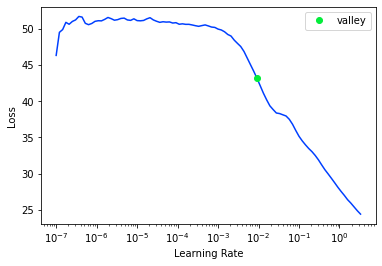

<Figure size 720x720 with 0 Axes>

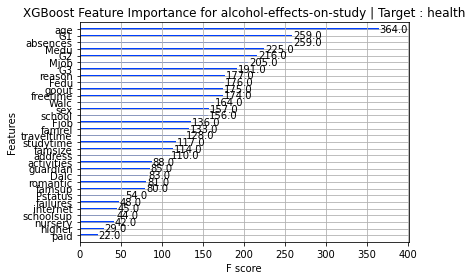

Target Variable: Walc
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 15.65it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.3776161640903771, 'Adjusted R-Squared': 0.17015488545383617, 'RMSE': 0.9564227820944782, 'Time taken': 0.13162946701049805}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3298941041785919, 'Adjusted R-Squared': 0.10652547223812259, 'RMSE': 0.9924130797859491, 'Time taken': 0.04981565475463867}
{'Model': 'BayesianRidge', 'R-Squared': 0.41789839979602517, 'Adjusted R-Squared': 0.2238645330613669, 'RMSE': 0.9249540463442582, 'Time taken': 0.034798622131347656}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.2078256603156432, 'Adjusted R-Squared': -0.6104342137541909, 'RMSE': 1.3323639887244072, 'Time taken': 0.05823111534118652}
{'Model': 'DummyRegressor', 'R-Squared': -0.0009314851301662763, 'Adjusted R-Squared': -0.3345753135068883, 'RMSE': 1.2128942447592992, 'Time taken': 0.04323554039001465}
{'Model': 'ElasticNet', 'R-Squared': 0.18153802449723566, 'Adjusted R-Squared': -0.09128263400368564, 'RMSE': 1.0967812410003814, 'Time taken': 0.02

 17%|█▋        | 7/42 [00:00<00:02, 12.38it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.41893980606392056, 'Adjusted R-Squared': 0.22525307475189416, 'RMSE': 0.9241262834995084, 'Time taken': 0.21478629112243652}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.09179000735955523, 'Adjusted R-Squared': -0.4557200098127403, 'RMSE': 1.2667482633857043, 'Time taken': 0.028083324432373047}


 21%|██▏       | 9/42 [00:00<00:03,  8.30it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3201249570692617, 'Adjusted R-Squared': 0.09349994275901563, 'RMSE': 0.9996208583583659, 'Time taken': 0.362088680267334}
{'Model': 'GammaRegressor', 'R-Squared': 0.3883114417890311, 'Adjusted R-Squared': 0.1844152557187082, 'RMSE': 0.9481694069356889, 'Time taken': 0.023137331008911133}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.615767102901226, 'Adjusted R-Squared': -5.154356137201635, 'RMSE': 2.6046100010908497, 'Time taken': 0.06829261779785156}


 29%|██▊       | 12/42 [00:01<00:03,  9.00it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.40217013420658954, 'Adjusted R-Squared': 0.20289351227545271, 'RMSE': 0.9373667918527492, 'Time taken': 0.20177674293518066}


 40%|████      | 17/42 [00:01<00:02, 10.78it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.31920418729611544, 'Adjusted R-Squared': 0.09227224972815395, 'RMSE': 1.000297533620161, 'Time taken': 0.2957932949066162}
{'Model': 'HuberRegressor', 'R-Squared': 0.3663443868650408, 'Adjusted R-Squared': 0.15512584915338778, 'RMSE': 0.9650446405981148, 'Time taken': 0.048154354095458984}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.1997759424319242, 'Adjusted R-Squared': -0.06696541009076773, 'RMSE': 1.0844925223383295, 'Time taken': 0.026459932327270508}
{'Model': 'KernelRidge', 'R-Squared': -3.1717003202335707, 'Adjusted R-Squared': -4.562267093644761, 'RMSE': 2.4761520616970674, 'Time taken': 0.03331780433654785}
{'Model': 'Lars', 'R-Squared': 0.4051406876446443, 'Adjusted R-Squared': 0.20685425019285908, 'RMSE': 0.9350350534306183, 'Time taken': 0.03554272651672363}


 45%|████▌     | 19/42 [00:01<00:02, 11.42it/s]

{'Model': 'LarsCV', 'R-Squared': 0.4186202614495498, 'Adjusted R-Squared': 0.2248270152660664, 'RMSE': 0.9243803526926234, 'Time taken': 0.11568284034729004}
{'Model': 'Lasso', 'R-Squared': -0.0009314851301662763, 'Adjusted R-Squared': -0.3345753135068883, 'RMSE': 1.2128942447592992, 'Time taken': 0.02408742904663086}
{'Model': 'LassoCV', 'R-Squared': 0.4167341092759733, 'Adjusted R-Squared': 0.22231214570129776, 'RMSE': 0.9258786076812575, 'Time taken': 0.15014338493347168}


 55%|█████▍    | 23/42 [00:02<00:01, 11.86it/s]

{'Model': 'LassoLars', 'R-Squared': -0.0009314851301662763, 'Adjusted R-Squared': -0.3345753135068883, 'RMSE': 1.2128942447592992, 'Time taken': 0.028281211853027344}
{'Model': 'LassoLarsCV', 'R-Squared': 0.4186202614495498, 'Adjusted R-Squared': 0.2248270152660664, 'RMSE': 0.9243803526926234, 'Time taken': 0.0943610668182373}
{'Model': 'LassoLarsIC', 'R-Squared': 0.4126328208081522, 'Adjusted R-Squared': 0.21684376107753633, 'RMSE': 0.9291281062580792, 'Time taken': 0.0453639030456543}
{'Model': 'LinearRegression', 'R-Squared': 0.4051406876446435, 'Adjusted R-Squared': 0.20685425019285808, 'RMSE': 0.9350350534306189, 'Time taken': 0.024635791778564453}


 60%|█████▉    | 25/42 [00:02<00:01, 13.39it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.3407153198078373, 'Adjusted R-Squared': 0.12095375974378308, 'RMSE': 0.98436746727366, 'Time taken': 0.06490349769592285}


 64%|██████▍   | 27/42 [00:03<00:03,  4.14it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.3288614464934011, 'Adjusted R-Squared': 0.1051485953245348, 'RMSE': 0.9931774578354579, 'Time taken': 1.2108790874481201}
{'Model': 'NuSVR', 'R-Squared': 0.43029421811133384, 'Adjusted R-Squared': 0.24039229081511182, 'RMSE': 0.9150526299793107, 'Time taken': 0.07868742942810059}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.39534756758389733, 'Adjusted R-Squared': 0.1937967567785298, 'RMSE': 0.9427003366744504, 'Time taken': 0.024634122848510742}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.39534756758389733, 'Adjusted R-Squared': 0.1937967567785298, 'RMSE': 0.9427003366744504, 'Time taken': 0.03821730613708496}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.14594032527809842, 'Adjusted R-Squared': -0.5279204337041312, 'RMSE': 1.2977820446522033, 'Time taken': 0.025464773178100586}


 74%|███████▍  | 31/42 [00:03<00:01,  6.81it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.4081631932620534, 'Adjusted R-Squared': 0.21088425768273789, 'RMSE': 0.9326565517095293, 'Time taken': 0.035433292388916016}
{'Model': 'QuantileRegressor', 'R-Squared': -0.06541827559358282, 'Adjusted R-Squared': -0.4205577007914436, 'RMSE': 1.251355858240716, 'Time taken': 4.577085494995117}


 79%|███████▊  | 33/42 [00:08<00:06,  1.42it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -2.2654805952613275, 'Adjusted R-Squared': -3.3539741270151033, 'RMSE': 2.190757533030442, 'Time taken': 0.2792956829071045}


 90%|█████████ | 38/42 [00:09<00:01,  2.58it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.36257976531196334, 'Adjusted R-Squared': 0.1501063537492845, 'RMSE': 0.967907116435514, 'Time taken': 0.4092888832092285}
{'Model': 'Ridge', 'R-Squared': 0.4055621597744883, 'Adjusted R-Squared': 0.20741621303265112, 'RMSE': 0.9347037473236296, 'Time taken': 0.016597747802734375}
{'Model': 'RidgeCV', 'R-Squared': 0.4090077307062828, 'Adjusted R-Squared': 0.21201030760837714, 'RMSE': 0.9319908744767356, 'Time taken': 0.030004262924194336}
{'Model': 'SGDRegressor', 'R-Squared': 0.40236995684469823, 'Adjusted R-Squared': 0.20315994245959768, 'RMSE': 0.9372101228987108, 'Time taken': 0.025986433029174805}
{'Model': 'SVR', 'R-Squared': 0.4176048818609518, 'Adjusted R-Squared': 0.22347317581460246, 'RMSE': 0.9251872155936296, 'Time taken': 0.07741665840148926}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.4051406876446435, 'Adjusted R-Squared': 0.20685425019285808, 'RMSE': 0.9350350534306189, 'Time taken': 0.020430803298950195}
{'Mod

100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.327619328499942, 'Adjusted R-Squared': 0.10349243799992269, 'RMSE': 0.9940961, 'Time taken': 0.591001033782959}
{'Model': 'LGBMRegressor', 'R-Squared': 0.3261991453361818, 'Adjusted R-Squared': 0.1015988604482424, 'RMSE': 0.9951453975776771, 'Time taken': 0.0838782787322998}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: Walc
Walc
Target Standard Deviation: 1.3003128890645728
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                        0.24       0.43  0.92        0.08
ElasticNetCV                                 0.23       0.42  0.92        0.21
LassoLarsCV                                  0.22       0.42  0.92        0.09
LarsCV                                       0.22       0.42  0.92        0.12
BayesianRidge                                0.22       0.42  0.92        0.03
SVR    

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.3531036376953125.
Better model found at epoch 1 with _rmse value: 2.388685703277588.
Better model found at epoch 2 with _rmse value: 2.122487783432007.
Better model found at epoch 3 with _rmse value: 1.9067673683166504.
Better model found at epoch 4 with _rmse value: 1.6855580806732178.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       5       2.24
1       3       1.49
2       1       1.93
3       5       4.21
4       3       3.17
XGBoost RMSE:  0.99360484


<Figure size 432x288 with 0 Axes>

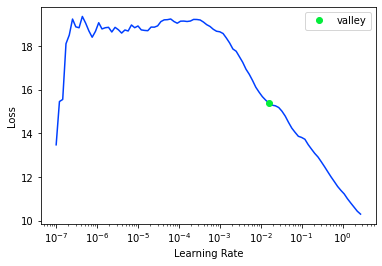

<Figure size 720x720 with 0 Axes>

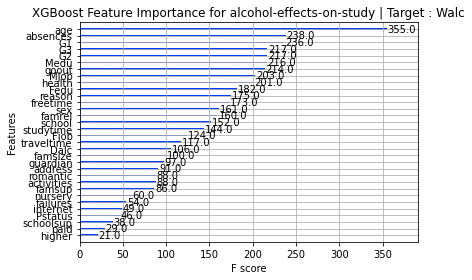

Target Variable: Dalc
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:01, 19.31it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.20286973344754533, 'Adjusted R-Squared': -0.06284035540327282, 'RMSE': 0.8853054413565971, 'Time taken': 0.12802481651306152}
{'Model': 'BaggingRegressor', 'R-Squared': 0.3798349834983499, 'Adjusted R-Squared': 0.17311331133113317, 'RMSE': 0.7808760733051469, 'Time taken': 0.04648566246032715}
{'Model': 'BayesianRidge', 'R-Squared': 0.316637617543185, 'Adjusted R-Squared': 0.08885015672424668, 'RMSE': 0.8196982689952951, 'Time taken': 0.027019023895263672}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.20627062706270616, 'Adjusted R-Squared': -0.6083608360836081, 'RMSE': 1.0890576254854043, 'Time taken': 0.0270082950592041}
{'Model': 'DummyRegressor', 'R-Squared': -0.016592653348175057, 'Adjusted R-Squared': -0.3554568711309001, 'RMSE': 0.9997742968078291, 'Time taken': 0.022095918655395508}
{'Model': 'ElasticNet', 'R-Squared': 0.027478813737049412, 'Adjusted R-Squared': -0.2966949150172673, 'RMSE': 0.9778630127622815, 'Time taken': 0.0

 17%|█▋        | 7/42 [00:00<00:02, 13.64it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.3729485071502049, 'Adjusted R-Squared': 0.1639313428669399, 'RMSE': 0.7851996311703907, 'Time taken': 0.22390151023864746}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.061789512284561865, 'Adjusted R-Squared': -0.25094731695391737, 'RMSE': 0.9604585468176327, 'Time taken': 0.045220375061035156}


 21%|██▏       | 9/42 [00:00<00:03,  9.47it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.20596960029336264, 'Adjusted R-Squared': -0.058707199608849736, 'RMSE': 0.8835823840804911, 'Time taken': 0.2858293056488037}
{'Model': 'GammaRegressor', 'R-Squared': 0.2731544012231204, 'Adjusted R-Squared': 0.030872534964160536, 'RMSE': 0.8453753230156738, 'Time taken': 0.021904468536376953}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -2.608719060667911, 'Adjusted R-Squared': -3.8116254142238812, 'RMSE': 1.8836708652971215, 'Time taken': 0.06650161743164062}


 29%|██▊       | 12/42 [00:01<00:02, 10.10it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.36297640757435823, 'Adjusted R-Squared': 0.15063521009914438, 'RMSE': 0.7914185807433495, 'Time taken': 0.17998552322387695}


 40%|████      | 17/42 [00:01<00:02, 11.25it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.3948265390681436, 'Adjusted R-Squared': 0.19310205209085818, 'RMSE': 0.7713800827110505, 'Time taken': 0.291501522064209}
{'Model': 'HuberRegressor', 'R-Squared': 0.31989574969277057, 'Adjusted R-Squared': 0.09319433292369417, 'RMSE': 0.8177418573727129, 'Time taken': 0.05128216743469238}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.06872753942060872, 'Adjusted R-Squared': -0.24169661410585497, 'RMSE': 0.9569006817474226, 'Time taken': 0.023146629333496094}
{'Model': 'KernelRidge', 'R-Squared': -2.1275378751879863, 'Adjusted R-Squared': -3.170050500250648, 'RMSE': 1.7535969149509083, 'Time taken': 0.03874516487121582}
{'Model': 'Lars', 'R-Squared': 0.3039929109200822, 'Adjusted R-Squared': 0.07199054789344295, 'RMSE': 0.8272472181578248, 'Time taken': 0.04422760009765625}


 45%|████▌     | 19/42 [00:01<00:02, 10.55it/s]

{'Model': 'LarsCV', 'R-Squared': 0.3764090567003945, 'Adjusted R-Squared': 0.1685454089338594, 'RMSE': 0.7830299676184681, 'Time taken': 0.16593551635742188}
{'Model': 'Lasso', 'R-Squared': -0.016592653348175057, 'Adjusted R-Squared': -0.3554568711309001, 'RMSE': 0.9997742968078291, 'Time taken': 0.053493499755859375}


 55%|█████▍    | 23/42 [00:02<00:01, 11.16it/s]

{'Model': 'LassoCV', 'R-Squared': 0.37574113998297654, 'Adjusted R-Squared': 0.16765485331063545, 'RMSE': 0.7834491998432088, 'Time taken': 0.16843795776367188}
{'Model': 'LassoLars', 'R-Squared': -0.016592653348175057, 'Adjusted R-Squared': -0.3554568711309001, 'RMSE': 0.9997742968078291, 'Time taken': 0.023076295852661133}
{'Model': 'LassoLarsCV', 'R-Squared': 0.3764090567003945, 'Adjusted R-Squared': 0.1685454089338594, 'RMSE': 0.7830299676184681, 'Time taken': 0.09118986129760742}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3416077665694567, 'Adjusted R-Squared': 0.12214368875927561, 'RMSE': 0.8045829653774828, 'Time taken': 0.05656695365905762}
{'Model': 'LinearRegression', 'R-Squared': 0.3039929109200824, 'Adjusted R-Squared': 0.07199054789344328, 'RMSE': 0.8272472181578246, 'Time taken': 0.025005102157592773}
{'Model': 'LinearSVR', 'R-Squared': 0.3506807729492344, 'Adjusted R-Squared': 0.13424103059897918, 'RMSE': 0.7990199360353143, 'Time taken': 0.05879783630371094}


 67%|██████▋   | 28/42 [00:03<00:02,  5.68it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.1035180691188774, 'Adjusted R-Squared': -0.19530924117483006, 'RMSE': 0.9388565794448248, 'Time taken': 1.2025597095489502}
{'Model': 'NuSVR', 'R-Squared': 0.25089179551837637, 'Adjusted R-Squared': 0.0011890606911685309, 'RMSE': 0.8582242082596071, 'Time taken': 0.09241223335266113}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.36074075285577467, 'Adjusted R-Squared': 0.14765433714103293, 'RMSE': 0.792806118846994, 'Time taken': 0.023786306381225586}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3436106569512438, 'Adjusted R-Squared': 0.1248142092683251, 'RMSE': 0.8033582251350757, 'Time taken': 0.0377500057220459}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.14032624655198744, 'Adjusted R-Squared': -0.5204349954026499, 'RMSE': 1.0588709754680963, 'Time taken': 0.024615049362182617}
{'Model': 'PoissonRegressor', 'R-Squared': 0.3162968205722205, 'Adjusted R-Squared': 0.08839576076296074, 'RMSE': 0.8199026377713352, '

 76%|███████▌  | 32/42 [00:07<00:05,  1.73it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.371837184000672, 'Adjusted R-Squared': -0.8291162453342293, 'RMSE': 1.1613945107412438, 'Time taken': 4.352327585220337}


 79%|███████▊  | 33/42 [00:08<00:04,  1.86it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.21824119927901187, 'Adjusted R-Squared': -0.6243215990386823, 'RMSE': 1.0944479829543186, 'Time taken': 0.259368896484375}


 90%|█████████ | 38/42 [00:08<00:01,  3.51it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.36417475247524755, 'Adjusted R-Squared': 0.15223300330033007, 'RMSE': 0.7906738368499806, 'Time taken': 0.37220096588134766}
{'Model': 'Ridge', 'R-Squared': 0.3044499810982565, 'Adjusted R-Squared': 0.07259997479767533, 'RMSE': 0.8269755455439589, 'Time taken': 0.01643204689025879}
{'Model': 'RidgeCV', 'R-Squared': 0.30786632599510166, 'Adjusted R-Squared': 0.07715510132680226, 'RMSE': 0.824942110606739, 'Time taken': 0.03068065643310547}
{'Model': 'SGDRegressor', 'R-Squared': 0.29777863192060594, 'Adjusted R-Squared': 0.063704842560808, 'RMSE': 0.8309320378166718, 'Time taken': 0.025940418243408203}
{'Model': 'SVR', 'R-Squared': 0.2516381567168806, 'Adjusted R-Squared': 0.002184208955840816, 'RMSE': 0.8577965631787984, 'Time taken': 0.0764613151550293}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3039929109200824, 'Adjusted R-Squared': 0.07199054789344328, 'RMSE': 0.8272472181578246, 'Time taken': 0.020579099655151367}
{'Mode

100%|██████████| 42/42 [00:09<00:00,  4.38it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.1339141007253073, 'Adjusted R-Squared': -0.15478119903292353, 'RMSE': 0.922803, 'Time taken': 0.621131181716919}
{'Model': 'LGBMRegressor', 'R-Squared': 0.4119195465903177, 'Adjusted R-Squared': 0.21589272878709032, 'RMSE': 0.7604083131828584, 'Time taken': 0.10561299324035645}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: Dalc
Dalc
Target Standard Deviation: 0.9048194432327762
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.22       0.41  0.76        0.11
HistGradientBoostingRegressor                0.19       0.39  0.77        0.29
BaggingRegressor                             0.17       0.38  0.78        0.05
LarsCV                                       0.17       0.38  0.78        0.17
LassoLarsCV                                  0.17       0.38  0.78        0.09
Lass

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.6168251037597656.
Better model found at epoch 1 with _rmse value: 1.3867127895355225.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.07
1       2       3.06
2       1       0.91
3       1       1.15
4       1       0.97
XGBoost RMSE:  0.9251055


<Figure size 432x288 with 0 Axes>

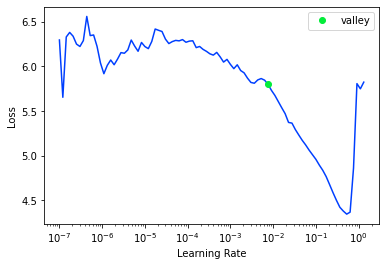

<Figure size 720x720 with 0 Axes>

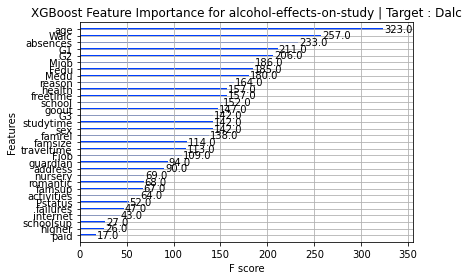

Target Variable: goout
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.18062343506906464, 'Adjusted R-Squared': -0.09250208657458048, 'RMSE': 1.0004592062623001, 'Time taken': 0.056398868560791016}


 12%|█▏        | 5/42 [00:00<00:01, 21.23it/s]

{'Model': 'BaggingRegressor', 'R-Squared': -0.057992916174734566, 'Adjusted R-Squared': -0.4106572215663127, 'RMSE': 1.1368390830610962, 'Time taken': 0.0507664680480957}
{'Model': 'BayesianRidge', 'R-Squared': 0.20677972709769266, 'Adjusted R-Squared': -0.05762703053640972, 'RMSE': 0.9843612709801555, 'Time taken': 0.037817955017089844}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -1.0116587957497045, 'Adjusted R-Squared': -1.6822117276662727, 'RMSE': 1.567598271587868, 'Time taken': 0.05853867530822754}
{'Model': 'DummyRegressor', 'R-Squared': -0.0006233206260521928, 'Adjusted R-Squared': -0.33416442750140285, 'RMSE': 1.1055870063225008, 'Time taken': 0.03440046310424805}
{'Model': 'ElasticNet', 'R-Squared': -0.0006233206260521928, 'Adjusted R-Squared': -0.33416442750140285, 'RMSE': 1.1055870063225008, 'Time taken': 0.027881383895874023}


 19%|█▉        | 8/42 [00:00<00:02, 16.14it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.1972653372390888, 'Adjusted R-Squared': -0.0703128836812148, 'RMSE': 0.9902472021364618, 'Time taken': 0.1688220500946045}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.7705135773317591, 'Adjusted R-Squared': -1.3606847697756788, 'RMSE': 1.4706429538383605, 'Time taken': 0.02844977378845215}


 24%|██▍       | 10/42 [00:00<00:03,  9.27it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.0843119539551358, 'Adjusted R-Squared': -0.22091739472648553, 'RMSE': 1.0576242207173878, 'Time taken': 0.3813140392303467}
{'Model': 'GammaRegressor', 'R-Squared': 0.18890287124664584, 'Adjusted R-Squared': -0.08146283833780554, 'RMSE': 0.995391774813996, 'Time taken': 0.019893407821655273}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -8.10001860961459, 'Adjusted R-Squared': -11.133358146152787, 'RMSE': 3.3341010319874282, 'Time taken': 0.11201167106628418}


 29%|██▊       | 12/42 [00:01<00:03,  8.21it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.19063311693342289, 'Adjusted R-Squared': -0.07915584408876941, 'RMSE': 0.9943295149811059, 'Time taken': 0.18665528297424316}


 33%|███▎      | 14/42 [00:01<00:03,  7.14it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.03987680972597185, 'Adjusted R-Squared': -0.2801642536987041, 'RMSE': 1.082981643678167, 'Time taken': 0.3002924919128418}
{'Model': 'HuberRegressor', 'R-Squared': 0.1941669819418712, 'Adjusted R-Squared': -0.07444402407750506, 'RMSE': 0.9921564150713172, 'Time taken': 0.05864548683166504}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.010017709563163946, 'Adjusted R-Squared': -0.3466902794175519, 'RMSE': 1.110764803913233, 'Time taken': 0.025331974029541016}
{'Model': 'KernelRidge', 'R-Squared': -7.665043265209279, 'Adjusted R-Squared': -10.553391020279038, 'RMSE': 3.2534413604623094, 'Time taken': 0.04953598976135254}
{'Model': 'Lars', 'R-Squared': 0.2015968407991776, 'Adjusted R-Squared': -0.06453754560109637, 'RMSE': 0.9875719339035488, 'Time taken': 0.06283879280090332}


 45%|████▌     | 19/42 [00:01<00:02, 10.53it/s]

{'Model': 'LarsCV', 'R-Squared': 0.192875597992744, 'Adjusted R-Squared': -0.07616586934300784, 'RMSE': 0.992951084645774, 'Time taken': 0.10352945327758789}
{'Model': 'Lasso', 'R-Squared': -0.0006233206260521928, 'Adjusted R-Squared': -0.33416442750140285, 'RMSE': 1.1055870063225008, 'Time taken': 0.03543281555175781}


 50%|█████     | 21/42 [00:02<00:02,  9.32it/s]

{'Model': 'LassoCV', 'R-Squared': 0.19878166450728307, 'Adjusted R-Squared': -0.06829111399028909, 'RMSE': 0.9893114953215246, 'Time taken': 0.2229173183441162}
{'Model': 'LassoLars', 'R-Squared': -0.0006233206260521928, 'Adjusted R-Squared': -0.33416442750140285, 'RMSE': 1.1055870063225008, 'Time taken': 0.046392202377319336}
{'Model': 'LassoLarsCV', 'R-Squared': 0.192875597992744, 'Adjusted R-Squared': -0.07616586934300784, 'RMSE': 0.992951084645774, 'Time taken': 0.13296818733215332}


 60%|█████▉    | 25/42 [00:02<00:01, 10.27it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.20513494566370682, 'Adjusted R-Squared': -0.059820072448390826, 'RMSE': 0.9853813033516021, 'Time taken': 0.08339619636535645}
{'Model': 'LinearRegression', 'R-Squared': 0.20159684079917728, 'Adjusted R-Squared': -0.06453754560109681, 'RMSE': 0.987571933903549, 'Time taken': 0.06015133857727051}
{'Model': 'LinearSVR', 'R-Squared': 0.16811099189565037, 'Adjusted R-Squared': -0.10918534413913283, 'RMSE': 1.0080691139728835, 'Time taken': 0.07094812393188477}


 74%|███████▍  | 31/42 [00:03<00:01,  6.49it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.15564891197123742, 'Adjusted R-Squared': -0.5408652159616498, 'RMSE': 1.1881480869837093, 'Time taken': 1.2190594673156738}
{'Model': 'NuSVR', 'R-Squared': 0.1371175463205665, 'Adjusted R-Squared': -0.15050993823924452, 'RMSE': 1.0266760585728936, 'Time taken': 0.07172036170959473}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.15651102831597186, 'Adjusted R-Squared': -0.12465196224537078, 'RMSE': 1.0150731027988946, 'Time taken': 0.026766300201416016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.18718200887990954, 'Adjusted R-Squared': -0.08375732149345394, 'RMSE': 0.9964471506670204, 'Time taken': 0.03545832633972168}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.3854222318796423, 'Adjusted R-Squared': -0.8472296425061896, 'RMSE': 1.3009143130798142, 'Time taken': 0.025444984436035156}
{'Model': 'PoissonRegressor', 'R-Squared': 0.21338172136101907, 'Adjusted R-Squared': -0.04882437151864116, 'RMSE': 0.9802562786041

 79%|███████▊  | 33/42 [00:08<00:05,  1.54it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -2.180850903122062, 'Adjusted R-Squared': -3.241134537496082, 'RMSE': 1.9711935622287238, 'Time taken': 0.28157639503479004}


 90%|█████████ | 38/42 [00:08<00:01,  2.74it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.057259902597402434, 'Adjusted R-Squared': -0.2569867965367967, 'RMSE': 1.0731331365129728, 'Time taken': 0.42612338066101074}
{'Model': 'Ridge', 'R-Squared': 0.20172389636568777, 'Adjusted R-Squared': -0.06436813817908282, 'RMSE': 0.9874933511083313, 'Time taken': 0.016457796096801758}
{'Model': 'RidgeCV', 'R-Squared': 0.2027883797025669, 'Adjusted R-Squared': -0.06294882706324412, 'RMSE': 0.9868347313183982, 'Time taken': 0.04536604881286621}
{'Model': 'SGDRegressor', 'R-Squared': 0.19521498419016325, 'Adjusted R-Squared': -0.07304668774644885, 'RMSE': 0.9915110453639349, 'Time taken': 0.026794910430908203}
{'Model': 'SVR', 'R-Squared': 0.10081576856126262, 'Adjusted R-Squared': -0.1989123085849831, 'RMSE': 1.0480498903215476, 'Time taken': 0.08258843421936035}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.20159684079917728, 'Adjusted R-Squared': -0.06453754560109681, 'RMSE': 0.987571933903549, 'Time taken': 0.0174324512481689

100%|██████████| 42/42 [00:09<00:00,  4.39it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.128806190309247, 'Adjusted R-Squared': -0.5050749204123293, 'RMSE': 1.1742682, 'Time taken': 0.5878510475158691}
{'Model': 'LGBMRegressor', 'R-Squared': 0.10067016271932272, 'Adjusted R-Squared': -0.19910644970756963, 'RMSE': 1.048134742793423, 'Time taken': 0.08969330787658691}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: goout
goout
Target Standard Deviation: 1.1914373374181635
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
PoissonRegressor                            -0.05       0.21  0.98        0.03
BayesianRidge                               -0.06       0.21  0.98        0.04
LassoLarsIC                                 -0.06       0.21  0.99        0.08
RidgeCV                                     -0.06       0.20  0.99        0.05
Ridge                                       -0.06       0.20  0.99        0.02


LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.238994598388672.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       2.23
1       2       3.07
2       3       3.18
3       3       2.16
4       4       2.18
XGBoost RMSE:  1.1679599


<Figure size 432x288 with 0 Axes>

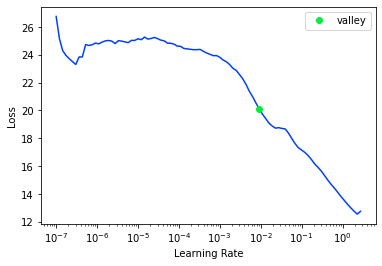

<Figure size 720x720 with 0 Axes>

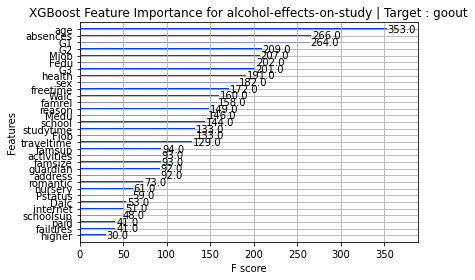

Target Variable: freetime
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 18.72it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.11804075381569112, 'Adjusted R-Squared': -0.17594566157907843, 'RMSE': 1.0548794465573634, 'Time taken': 0.1322002410888672}
{'Model': 'BaggingRegressor', 'R-Squared': 0.06598494951419331, 'Adjusted R-Squared': -0.24535340064774225, 'RMSE': 1.08556419082572, 'Time taken': 0.051618099212646484}
{'Model': 'BayesianRidge', 'R-Squared': 0.18954689720680673, 'Adjusted R-Squared': -0.08060413705759095, 'RMSE': 1.0112127024094413, 'Time taken': 0.023578882217407227}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.7449037911983236, 'Adjusted R-Squared': -1.3265383882644315, 'RMSE': 1.483762240925715, 'Time taken': 0.028136014938354492}
{'Model': 'DummyRegressor', 'R-Squared': -0.002903412991598353, 'Adjusted R-Squared': -0.3372045506554644, 'RMSE': 1.1248850019457115, 'Time taken': 0.0368044376373291}
{'Model': 'ElasticNet', 'R-Squared': -0.002903412991598353, 'Adjusted R-Squared': -0.3372045506554644, 'RMSE': 1.1248850019457115, 'Time taken': 0

 17%|█▋        | 7/42 [00:00<00:02, 13.64it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.18725670752267298, 'Adjusted R-Squared': -0.08365772330310262, 'RMSE': 1.012640443968702, 'Time taken': 0.20202875137329102}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.6957515717279481, 'Adjusted R-Squared': -1.2610020956372638, 'RMSE': 1.4627149017224546, 'Time taken': 0.026658296585083008}


 21%|██▏       | 9/42 [00:00<00:03,  8.53it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.1744964612307106, 'Adjusted R-Squared': -0.10067138502571904, 'RMSE': 1.0205588224485247, 'Time taken': 0.37387657165527344}
{'Model': 'GammaRegressor', 'R-Squared': 0.1504776444519963, 'Adjusted R-Squared': -0.13269647406400487, 'RMSE': 1.0352994367852313, 'Time taken': 0.022377729415893555}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -7.704996265845923, 'Adjusted R-Squared': -10.606661687794563, 'RMSE': 3.3140790728070018, 'Time taken': 0.06601452827453613}


 29%|██▊       | 12/42 [00:01<00:03,  9.21it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.11307165649481421, 'Adjusted R-Squared': -0.18257112467358105, 'RMSE': 1.0578469510656001, 'Time taken': 0.20014166831970215}


 40%|████      | 17/42 [00:01<00:02, 11.09it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.07396641828918837, 'Adjusted R-Squared': -0.2347114422810821, 'RMSE': 1.08091598615455, 'Time taken': 0.27773284912109375}
{'Model': 'HuberRegressor', 'R-Squared': 0.208772184736276, 'Adjusted R-Squared': -0.05497042035163191, 'RMSE': 0.9991468991729215, 'Time taken': 0.044524192810058594}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.00024385597256604274, 'Adjusted R-Squared': -0.3330081920365786, 'RMSE': 1.123118581823491, 'Time taken': 0.02555060386657715}
{'Model': 'KernelRidge', 'R-Squared': -7.546317934346387, 'Adjusted R-Squared': -10.395090579128516, 'RMSE': 3.283734942155734, 'Time taken': 0.0394444465637207}
{'Model': 'Lars', 'R-Squared': 0.212686242277478, 'Adjusted R-Squared': -0.04975167696336258, 'RMSE': 0.9966725379462829, 'Time taken': 0.03438305854797363}


 45%|████▌     | 19/42 [00:01<00:01, 11.97it/s]

{'Model': 'LarsCV', 'R-Squared': 0.18638661399881085, 'Adjusted R-Squared': -0.08481784800158554, 'RMSE': 1.0131823470581092, 'Time taken': 0.10085415840148926}
{'Model': 'Lasso', 'R-Squared': -0.002903412991598353, 'Adjusted R-Squared': -0.3372045506554644, 'RMSE': 1.1248850019457115, 'Time taken': 0.023001909255981445}


 55%|█████▍    | 23/42 [00:02<00:01, 11.50it/s]

{'Model': 'LassoCV', 'R-Squared': 0.19045542436905027, 'Adjusted R-Squared': -0.0793927675079329, 'RMSE': 1.0106457529953006, 'Time taken': 0.1789555549621582}
{'Model': 'LassoLars', 'R-Squared': -0.002903412991598353, 'Adjusted R-Squared': -0.3372045506554644, 'RMSE': 1.1248850019457115, 'Time taken': 0.025068283081054688}
{'Model': 'LassoLarsCV', 'R-Squared': 0.18638661399881085, 'Adjusted R-Squared': -0.08481784800158554, 'RMSE': 1.0131823470581092, 'Time taken': 0.09720301628112793}
{'Model': 'LassoLarsIC', 'R-Squared': 0.202972934349003, 'Adjusted R-Squared': -0.0627027542013292, 'RMSE': 1.002801803882312, 'Time taken': 0.05737161636352539}
{'Model': 'LinearRegression', 'R-Squared': 0.21268624227747768, 'Adjusted R-Squared': -0.04975167696336302, 'RMSE': 0.9966725379462831, 'Time taken': 0.03143715858459473}
{'Model': 'LinearSVR', 'R-Squared': 0.14818470591354027, 'Adjusted R-Squared': -0.13575372544861297, 'RMSE': 1.0366956792099353, 'Time taken': 0.05177736282348633}


 67%|██████▋   | 28/42 [00:03<00:02,  5.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.1560493074953283, 'Adjusted R-Squared': -0.12526759000622878, 'RMSE': 1.0318988030348861, 'Time taken': 1.1916866302490234}
{'Model': 'NuSVR', 'R-Squared': 0.18572117063272298, 'Adjusted R-Squared': -0.08570510582303603, 'RMSE': 1.0135965964310345, 'Time taken': 0.07703161239624023}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.21750398151916783, 'Adjusted R-Squared': -0.04332802464110941, 'RMSE': 0.993618433671941, 'Time taken': 0.02500629425048828}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.18326085920880997, 'Adjusted R-Squared': -0.08898552105491997, 'RMSE': 1.0151267126111898, 'Time taken': 0.03796529769897461}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.3994707253426182, 'Adjusted R-Squared': -0.8659609671234909, 'RMSE': 1.3288026355639917, 'Time taken': 0.02631378173828125}


 74%|███████▍  | 31/42 [00:03<00:01,  8.12it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.19461108967445095, 'Adjusted R-Squared': -0.07385188043406532, 'RMSE': 1.0080484227310076, 'Time taken': 0.035997867584228516}
{'Model': 'QuantileRegressor', 'R-Squared': -0.013764526590919202, 'Adjusted R-Squared': -0.3516860354545588, 'RMSE': 1.1309596665929624, 'Time taken': 4.5324866771698}


 79%|███████▊  | 33/42 [00:08<00:06,  1.42it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.4255410493593415, 'Adjusted R-Squared': -2.234054732479122, 'RMSE': 1.749374880793191, 'Time taken': 0.22787737846374512}


 90%|█████████ | 38/42 [00:09<00:01,  2.60it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.17122906744141753, 'Adjusted R-Squared': -0.10502791007810997, 'RMSE': 1.0225765451533075, 'Time taken': 0.42710280418395996}
{'Model': 'Ridge', 'R-Squared': 0.21292778175865135, 'Adjusted R-Squared': -0.049429624321798205, 'RMSE': 0.9965196419553393, 'Time taken': 0.013789653778076172}
{'Model': 'RidgeCV', 'R-Squared': 0.21425672553506636, 'Adjusted R-Squared': -0.04765769928657804, 'RMSE': 0.9956779923364564, 'Time taken': 0.04383397102355957}
{'Model': 'SGDRegressor', 'R-Squared': 0.2136802031999876, 'Adjusted R-Squared': -0.048426395733349725, 'RMSE': 0.9960432040810044, 'Time taken': 0.05407238006591797}
{'Model': 'SVR', 'R-Squared': 0.1865914712654243, 'Adjusted R-Squared': -0.08454470497943412, 'RMSE': 1.0130547859606014, 'Time taken': 0.0634772777557373}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.21268624227747768, 'Adjusted R-Squared': -0.04975167696336302, 'RMSE': 0.9966725379462831, 'Time taken': 0.018555164337158

100%|██████████| 42/42 [00:09<00:00,  4.31it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.09656770924408598, 'Adjusted R-Squared': -0.20457638767455188, 'RMSE': 1.0676438, 'Time taken': 0.5987310409545898}
{'Model': 'LGBMRegressor', 'R-Squared': 0.09124281369112497, 'Adjusted R-Squared': -0.2116762484118333, 'RMSE': 1.0707855475422048, 'Time taken': 0.08388280868530273}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: freetime
freetime
Target Standard Deviation: 1.0310275221735303
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuit                   -0.04       0.22  0.99        0.03
RidgeCV                                     -0.05       0.21  1.00        0.04
SGDRegressor                                -0.05       0.21  1.00        0.05
Ridge                                       -0.05       0.21  1.00        0.01
Lars                                        -0.05       0.21  1.00     

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.8202435970306396.
No improvement since epoch 0: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.72
1       3       3.94
2       4       4.26
3       2       4.78
4       4       3.06
XGBoost RMSE:  1.0677094


<Figure size 432x288 with 0 Axes>

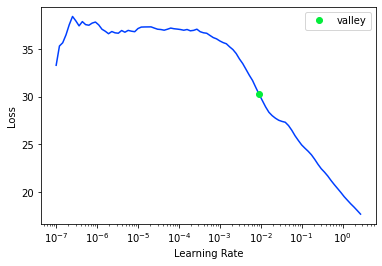

<Figure size 720x720 with 0 Axes>

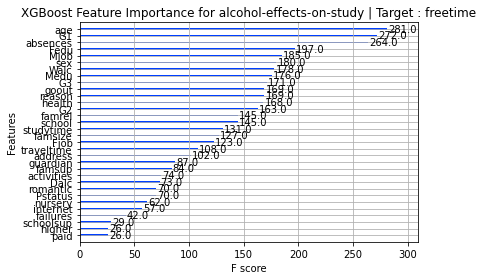

Target Variable: famrel
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 12%|█▏        | 5/42 [00:00<00:01, 21.82it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.07963647703556598, 'Adjusted R-Squared': -0.22715136395257862, 'RMSE': 0.928745242003962, 'Time taken': 0.08130073547363281}
{'Model': 'BaggingRegressor', 'R-Squared': -0.04831110541164407, 'Adjusted R-Squared': -0.39774814054885876, 'RMSE': 0.9912016041931322, 'Time taken': 0.05166435241699219}
{'Model': 'BayesianRidge', 'R-Squared': 0.033798513734593416, 'Adjusted R-Squared': -0.28826864835387545, 'RMSE': 0.9515919370709024, 'Time taken': 0.042781829833984375}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.7700692485252629, 'Adjusted R-Squared': -1.3600923313670172, 'RMSE': 1.287988636860656, 'Time taken': 0.04354739189147949}
{'Model': 'DummyRegressor', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.0206451416015625}
{'Model': 'ElasticNet', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken

 19%|█▉        | 8/42 [00:00<00:02, 11.87it/s]

{'Model': 'ElasticNetCV', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.26947665214538574}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -1.0678379071556812, 'Adjusted R-Squared': -1.7571172095409082, 'RMSE': 1.3921151159742613, 'Time taken': 0.057553768157958984}


 24%|██▍       | 10/42 [00:00<00:03,  8.47it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.01153543216209274, 'Adjusted R-Squared': -0.3179527571172096, 'RMSE': 0.9624927262384977, 'Time taken': 0.3579106330871582}
{'Model': 'GammaRegressor', 'R-Squared': 0.053467324364694147, 'Adjusted R-Squared': -0.26204356751374114, 'RMSE': 0.9418564331176092, 'Time taken': 0.02021956443786621}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -15.519471072442297, 'Adjusted R-Squared': -21.02596142992306, 'RMSE': 3.934730319715634, 'Time taken': 0.06740617752075195}


 29%|██▊       | 12/42 [00:01<00:03,  8.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0008618768268926491, 'Adjusted R-Squared': -0.33218416423080965, 'RMSE': 0.967675327406328, 'Time taken': 0.1989738941192627}


 40%|████      | 17/42 [00:01<00:02, 10.24it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.03240972772841677, 'Adjusted R-Squared': -0.3765463036378889, 'RMSE': 0.9836553240977997, 'Time taken': 0.2902257442474365}
{'Model': 'HuberRegressor', 'R-Squared': 0.015982512672650495, 'Adjusted R-Squared': -0.31202331643646586, 'RMSE': 0.9603251686605779, 'Time taken': 0.05947566032409668}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.06171069505001303, 'Adjusted R-Squared': -0.4156142600666839, 'RMSE': 0.9975162954508175, 'Time taken': 0.026076316833496094}
{'Model': 'KernelRidge', 'R-Squared': -15.369771678223067, 'Adjusted R-Squared': -20.826362237630754, 'RMSE': 3.9168614889547024, 'Time taken': 0.03796529769897461}
{'Model': 'Lars', 'R-Squared': 0.055948275090532795, 'Adjusted R-Squared': -0.25873563321262294, 'RMSE': 0.9406212762928668, 'Time taken': 0.037746429443359375}


 45%|████▌     | 19/42 [00:01<00:02, 10.69it/s]

{'Model': 'LarsCV', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.12300729751586914}
{'Model': 'Lasso', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.0379488468170166}


 50%|█████     | 21/42 [00:02<00:02,  9.37it/s]

{'Model': 'LassoCV', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.24884390830993652}
{'Model': 'LassoLars', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.02664041519165039}
{'Model': 'LassoLarsCV', 'R-Squared': -0.019731505461118015, 'Adjusted R-Squared': -0.35964200728149054, 'RMSE': 0.9775969133373655, 'Time taken': 0.11641550064086914}


 60%|█████▉    | 25/42 [00:02<00:01, 11.16it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.05585524937714692, 'Adjusted R-Squared': -0.2588596674971373, 'RMSE': 0.940667618991824, 'Time taken': 0.06438684463500977}
{'Model': 'LinearRegression', 'R-Squared': 0.05594827509053368, 'Adjusted R-Squared': -0.2587356332126216, 'RMSE': 0.9406212762928665, 'Time taken': 0.047435760498046875}
{'Model': 'LinearSVR', 'R-Squared': -0.03389068629992931, 'Adjusted R-Squared': -0.37852091506657226, 'RMSE': 0.9843605822441647, 'Time taken': 0.06354165077209473}


 64%|██████▍   | 27/42 [00:03<00:03,  4.02it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.1899086142172517, 'Adjusted R-Squared': -0.5865448189563356, 'RMSE': 1.056023802619217, 'Time taken': 1.1795189380645752}
{'Model': 'NuSVR', 'R-Squared': -0.021190398473861283, 'Adjusted R-Squared': -0.3615871979651484, 'RMSE': 0.9782959696853127, 'Time taken': 0.07494759559631348}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.015468200031557688, 'Adjusted R-Squared': -0.31270906662458975, 'RMSE': 0.960576100610393, 'Time taken': 0.025064468383789062}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': -0.032634749034029964, 'Adjusted R-Squared': -0.3768463320453732, 'RMSE': 0.9837625157194083, 'Time taken': 0.03794360160827637}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.8492696849208217, 'Adjusted R-Squared': -1.465692913227762, 'RMSE': 1.3164883738509712, 'Time taken': 0.026573657989501953}
{'Model': 'PoissonRegressor', 'R-Squared': 0.070373762937187, 'Adjusted R-Squared': -0.23950164941708385, 'RMSE': 0.933407076628829

 74%|███████▍  | 31/42 [00:03<00:01,  6.69it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.033918953620680536, 'Adjusted R-Squared': -0.378558604827574, 'RMSE': 0.9843740387180907, 'Time taken': 3.7461304664611816}


 79%|███████▊  | 33/42 [00:07<00:05,  1.64it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.37932574513120754, 'Adjusted R-Squared': -0.8391009935082767, 'RMSE': 1.1369734520009838, 'Time taken': 0.27958250045776367}


 88%|████████▊ | 37/42 [00:08<00:01,  2.58it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.09703308540651445, 'Adjusted R-Squared': -0.20395588612464732, 'RMSE': 0.9199258480396519, 'Time taken': 0.4373328685760498}
{'Model': 'Ridge', 'R-Squared': 0.05712272670236118, 'Adjusted R-Squared': -0.25716969773018494, 'RMSE': 0.9400360022343098, 'Time taken': 0.015787363052368164}
{'Model': 'RidgeCV', 'R-Squared': 0.06424918360910015, 'Adjusted R-Squared': -0.24766775518786632, 'RMSE': 0.9364767731320071, 'Time taken': 0.04241752624511719}
{'Model': 'SGDRegressor', 'R-Squared': 0.06428192734207461, 'Adjusted R-Squared': -0.24762409687723386, 'RMSE': 0.9364603884208694, 'Time taken': 0.06206536293029785}
{'Model': 'SVR', 'R-Squared': -0.02409217504811223, 'Adjusted R-Squared': -0.3654562333974829, 'RMSE': 0.9796849283640489, 'Time taken': 0.060423851013183594}


 95%|█████████▌| 40/42 [00:08<00:00,  3.78it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.05594827509053368, 'Adjusted R-Squared': -0.2587356332126216, 'RMSE': 0.9406212762928665, 'Time taken': 0.027482271194458008}
{'Model': 'TweedieRegressor', 'R-Squared': 0.05173960795407806, 'Adjusted R-Squared': -0.2643471893945626, 'RMSE': 0.9427156316273473, 'Time taken': 0.0610499382019043}


100%|██████████| 42/42 [00:09<00:00,  4.47it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.01724329943886449, 'Adjusted R-Squared': -0.35632439925181925, 'RMSE': 0.9764035, 'Time taken': 0.6701653003692627}
{'Model': 'LGBMRegressor', 'R-Squared': -0.02221737235729604, 'Adjusted R-Squared': -0.3629564964763947, 'RMSE': 0.9787877643329934, 'Time taken': 0.08439326286315918}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: famrel
famrel
Target Standard Deviation: 0.9497663991833737
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                       -0.20       0.10  0.92        0.44
AdaBoostRegressor                           -0.23       0.08  0.93        0.08
PoissonRegressor                            -0.24       0.07  0.93        0.03
SGDRegressor                                -0.25       0.06  0.94        0.06
RidgeCV                                     -0.25       0.06  0.94       

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.7940022945404053.
Better model found at epoch 1 with _rmse value: 1.5255804061889648.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       4       3.69
1       4       4.48
2       4       3.16
3       3       3.17
4       4       3.74
XGBoost RMSE:  0.97685575


<Figure size 432x288 with 0 Axes>

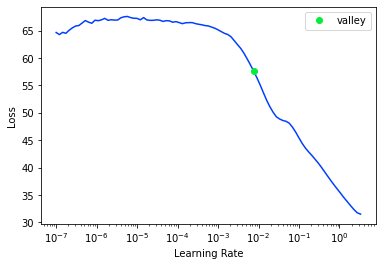

<Figure size 720x720 with 0 Axes>

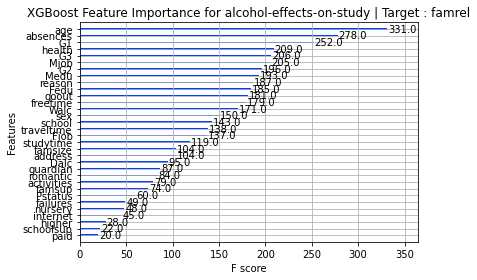

Target Variable: failures
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 14%|█▍        | 6/42 [00:00<00:01, 27.22it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.03902743087275762, 'Adjusted R-Squared': -0.3853699078303434, 'RMSE': 0.4597982068454352, 'Time taken': 0.09256172180175781}
{'Model': 'BaggingRegressor', 'R-Squared': 0.1325073833431777, 'Adjusted R-Squared': -0.15665682220909627, 'RMSE': 0.4201328693484679, 'Time taken': 0.04109692573547363}
{'Model': 'BayesianRidge', 'R-Squared': 0.15337668901735524, 'Adjusted R-Squared': -0.12883108131019294, 'RMSE': 0.4150485277543294, 'Time taken': 0.02423715591430664}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.5620200826934436, 'Adjusted R-Squared': -1.0826934435912579, 'RMSE': 0.5637636538163321, 'Time taken': 0.02564525604248047}
{'Model': 'DummyRegressor', 'R-Squared': -0.02017619103373791, 'Adjusted R-Squared': -0.36023492137831714, 'RMSE': 0.4556080180552502, 'Time taken': 0.02996206283569336}
{'Model': 'ElasticNet', 'R-Squared': -0.02017619103373791, 'Adjusted R-Squared': -0.36023492137831714, 'RMSE': 0.4556080180552502, 'Time taken': 

 26%|██▌       | 11/42 [00:00<00:02, 11.50it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.030419846426461894, 'Adjusted R-Squared': -0.29277353809805073, 'RMSE': 0.4441663212471569, 'Time taken': 0.2954139709472656}
{'Model': 'GammaRegressor', 'R-Squared': 0.22166397811833505, 'Adjusted R-Squared': -0.03778136250888653, 'RMSE': 0.39795808445920305, 'Time taken': 0.02230668067932129}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -6.584808999109633, 'Adjusted R-Squared': -9.11307866547951, 'RMSE': 1.2422988723535973, 'Time taken': 0.1159512996673584}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.07875646313267448, 'Adjusted R-Squared': -0.22832471582310054, 'RMSE': 0.4329532395672188, 'Time taken': 0.17877721786499023}


 36%|███▌      | 15/42 [00:01<00:03,  8.62it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.12508607590290088, 'Adjusted R-Squared': -0.5001147678705344, 'RMSE': 0.4784611078544383, 'Time taken': 0.28115177154541016}
{'Model': 'HuberRegressor', 'R-Squared': -0.14285023535343622, 'Adjusted R-Squared': -0.5238003138045815, 'RMSE': 0.48222356303286346, 'Time taken': 0.13841867446899414}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.018594211458948462, 'Adjusted R-Squared': -0.30854105138806864, 'RMSE': 0.44686678381886946, 'Time taken': 0.02592754364013672}
{'Model': 'KernelRidge', 'R-Squared': -7.137366152282572, 'Adjusted R-Squared': -9.849821536376762, 'RMSE': 1.2867544997774367, 'Time taken': 0.03202033042907715}


 43%|████▎     | 18/42 [00:01<00:02, 10.48it/s]

{'Model': 'Lars', 'R-Squared': 0.04999968538755817, 'Adjusted R-Squared': -0.2666670861499223, 'RMSE': 0.4396586693388086, 'Time taken': 0.03835701942443848}
{'Model': 'LarsCV', 'R-Squared': 0.19576951719941482, 'Adjusted R-Squared': -0.07230731040078009, 'RMSE': 0.4045237566188879, 'Time taken': 0.11658883094787598}
{'Model': 'Lasso', 'R-Squared': -0.02017619103373791, 'Adjusted R-Squared': -0.36023492137831714, 'RMSE': 0.4556080180552502, 'Time taken': 0.03803539276123047}


 52%|█████▏    | 22/42 [00:02<00:02,  9.92it/s]

{'Model': 'LassoCV', 'R-Squared': 0.19104102515060228, 'Adjusted R-Squared': -0.07861196646586355, 'RMSE': 0.4057112172244533, 'Time taken': 0.2400810718536377}
{'Model': 'LassoLars', 'R-Squared': -0.02017619103373791, 'Adjusted R-Squared': -0.36023492137831714, 'RMSE': 0.4556080180552502, 'Time taken': 0.04915785789489746}
{'Model': 'LassoLarsCV', 'R-Squared': 0.1932154308703954, 'Adjusted R-Squared': -0.07571275883947282, 'RMSE': 0.4051655935144902, 'Time taken': 0.10659265518188477}


 60%|█████▉    | 25/42 [00:02<00:01, 12.99it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.1871133930747948, 'Adjusted R-Squared': -0.08384880923360694, 'RMSE': 0.4066949228029342, 'Time taken': 0.044811248779296875}
{'Model': 'LinearRegression', 'R-Squared': 0.05046528084288682, 'Adjusted R-Squared': -0.26604629220948417, 'RMSE': 0.4395509177083092, 'Time taken': 0.022762537002563477}
{'Model': 'LinearSVR', 'R-Squared': -0.14294887623615704, 'Adjusted R-Squared': -0.5239318349815427, 'RMSE': 0.48224437325370767, 'Time taken': 0.03705167770385742}


 64%|██████▍   | 27/42 [00:03<00:03,  4.40it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.5279495223098585, 'Adjusted R-Squared': -1.037266029746478, 'RMSE': 0.5575813898815472, 'Time taken': 1.1606626510620117}
{'Model': 'NuSVR', 'R-Squared': 0.12137389411432642, 'Adjusted R-Squared': -0.17150147451423137, 'RMSE': 0.42282028835659274, 'Time taken': 0.13323736190795898}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.17674642981514654, 'Adjusted R-Squared': -0.0976714269131378, 'RMSE': 0.40928005200185785, 'Time taken': 0.016726016998291016}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.14661762154043334, 'Adjusted R-Squared': -0.13784317127942214, 'RMSE': 0.416702016417481, 'Time taken': 0.038507938385009766}


 74%|███████▍  | 31/42 [00:03<00:01,  7.03it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.9310281261842936, 'Adjusted R-Squared': -1.5747041682457246, 'RMSE': 0.626827535902532, 'Time taken': 0.026893138885498047}
{'Model': 'PoissonRegressor', 'R-Squared': 0.21953377714809508, 'Adjusted R-Squared': -0.040621630469206416, 'RMSE': 0.39850229122528913, 'Time taken': 0.030215978622436523}
{'Model': 'QuantileRegressor', 'R-Squared': -0.14294152390763948, 'Adjusted R-Squared': -0.5239220318768525, 'RMSE': 0.4822428221673758, 'Time taken': 4.270698070526123}


 79%|███████▊  | 33/42 [00:08<00:05,  1.50it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.14294152392203197, 'Adjusted R-Squared': -0.5239220318960425, 'RMSE': 0.4822428221704121, 'Time taken': 0.4600543975830078}


 88%|████████▊ | 37/42 [00:08<00:02,  2.39it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.16563744831659788, 'Adjusted R-Squared': -0.11248340224453601, 'RMSE': 0.41203221067734364, 'Time taken': 0.3616757392883301}
{'Model': 'Ridge', 'R-Squared': 0.052040505279940086, 'Adjusted R-Squared': -0.2639459929600798, 'RMSE': 0.43918617130625826, 'Time taken': 0.03143668174743652}
{'Model': 'RidgeCV', 'R-Squared': 0.06489916682876917, 'Adjusted R-Squared': -0.24680111089497436, 'RMSE': 0.4361973156017814, 'Time taken': 0.06428694725036621}
{'Model': 'SGDRegressor', 'R-Squared': 0.06515267608176678, 'Adjusted R-Squared': -0.24646309855764414, 'RMSE': 0.43613818425070394, 'Time taken': 0.05135059356689453}


 95%|█████████▌| 40/42 [00:09<00:00,  3.52it/s]

{'Model': 'SVR', 'R-Squared': 0.11145203821994976, 'Adjusted R-Squared': -0.18473061570673366, 'RMSE': 0.4252009283769895, 'Time taken': 0.07222962379455566}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.05046528084288682, 'Adjusted R-Squared': -0.26604629220948417, 'RMSE': 0.4395509177083092, 'Time taken': 0.018107175827026367}
{'Model': 'TweedieRegressor', 'R-Squared': 0.20888261683179254, 'Adjusted R-Squared': -0.05482317755760979, 'RMSE': 0.4012122921492378, 'Time taken': 0.04242825508117676}


100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.22022824093028492, 'Adjusted R-Squared': -0.6269709879070464, 'RMSE': 0.49828097, 'Time taken': 0.6940808296203613}
{'Model': 'LGBMRegressor', 'R-Squared': -0.07891874168842561, 'Adjusted R-Squared': -0.43855832225123415, 'RMSE': 0.46854157726315165, 'Time taken': 0.09334421157836914}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: failures
failures
Target Standard Deviation: 0.6223048397766705
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GammaRegressor                              -0.04       0.22  0.40        0.02
PoissonRegressor                            -0.04       0.22  0.40        0.03
TweedieRegressor                            -0.05       0.21  0.40        0.04
LarsCV                                      -0.07       0.20  0.40        0.12
ElasticNetCV                                -0.07       0.19  0.40 

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.7732306718826294.
Better model found at epoch 1 with _rmse value: 0.8635879755020142.
Better model found at epoch 2 with _rmse value: 0.7909650206565857.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.05
1       1       2.05
2       2       1.22
3       1       2.12
4       1       1.37
XGBoost RMSE:  0.49746686


<Figure size 432x288 with 0 Axes>

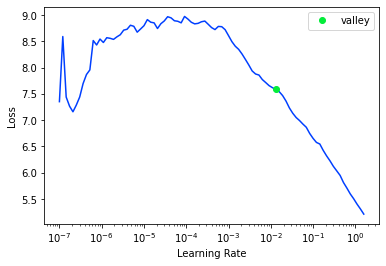

<Figure size 720x720 with 0 Axes>

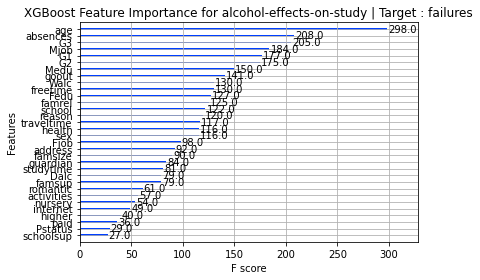

Target Variable: studytime
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.07802401369755785, 'Adjusted R-Squared': -0.2293013150699228, 'RMSE': 0.843305530935965, 'Time taken': 0.05756330490112305}


 12%|█▏        | 5/42 [00:00<00:01, 20.38it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.17309753817388596, 'Adjusted R-Squared': -0.10253661576815198, 'RMSE': 0.7986422586892964, 'Time taken': 0.051193952560424805}
{'Model': 'BayesianRidge', 'R-Squared': 0.1219395455962472, 'Adjusted R-Squared': -0.170747272538337, 'RMSE': 0.8229763461155146, 'Time taken': 0.03654837608337402}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.5175288251791836, 'Adjusted R-Squared': -1.0233717669055782, 'RMSE': 1.0819161869844238, 'Time taken': 0.05949568748474121}
{'Model': 'DummyRegressor', 'R-Squared': -0.00010826412078834835, 'Adjusted R-Squared': -0.3334776854943844, 'RMSE': 0.8783116673642732, 'Time taken': 0.04217362403869629}
{'Model': 'ElasticNet', 'R-Squared': -0.00010826412078834835, 'Adjusted R-Squared': -0.3334776854943844, 'RMSE': 0.8783116673642732, 'Time taken': 0.023710966110229492}


 19%|█▉        | 8/42 [00:00<00:02, 13.68it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.12158616468421757, 'Adjusted R-Squared': -0.17121844708770984, 'RMSE': 0.8231419354409423, 'Time taken': 0.20795226097106934}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.4371299470239951, 'Adjusted R-Squared': -0.9161732626986601, 'RMSE': 1.0528661509341755, 'Time taken': 0.057266950607299805}


 24%|██▍       | 10/42 [00:00<00:03,  9.33it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.11688063259582426, 'Adjusted R-Squared': -0.17749248987223432, 'RMSE': 0.8253437151042077, 'Time taken': 0.33849477767944336}
{'Model': 'GammaRegressor', 'R-Squared': 0.12205742330758851, 'Adjusted R-Squared': -0.17059010225654858, 'RMSE': 0.8229211028667356, 'Time taken': 0.014228343963623047}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.773984580734756, 'Adjusted R-Squared': -6.698646107646341, 'RMSE': 2.1103911345624, 'Time taken': 0.11159515380859375}


 29%|██▊       | 12/42 [00:01<00:03,  8.01it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.17788649005243307, 'Adjusted R-Squared': -0.09615134659675584, 'RMSE': 0.7963262582044229, 'Time taken': 0.21224546432495117}


 38%|███▊      | 16/42 [00:01<00:02,  9.51it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.1284893943279467, 'Adjusted R-Squared': -0.1620141408960709, 'RMSE': 0.8199011247462118, 'Time taken': 0.27733397483825684}
{'Model': 'HuberRegressor', 'R-Squared': 0.13436352758320957, 'Adjusted R-Squared': -0.1541819632223871, 'RMSE': 0.8171333147974749, 'Time taken': 0.04989004135131836}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.01631972577126839, 'Adjusted R-Squared': -0.311573698971642, 'RMSE': 0.8710681316191521, 'Time taken': 0.02590489387512207}
{'Model': 'KernelRidge', 'R-Squared': -4.809766319887022, 'Adjusted R-Squared': -6.7463550931826965, 'RMSE': 2.116920147129917, 'Time taken': 0.05480504035949707}


 43%|████▎     | 18/42 [00:01<00:02,  9.94it/s]

{'Model': 'Lars', 'R-Squared': 0.12159187440073427, 'Adjusted R-Squared': -0.17121083413235416, 'RMSE': 0.8231392602128478, 'Time taken': 0.07153129577636719}
{'Model': 'LarsCV', 'R-Squared': 0.12199383962239263, 'Adjusted R-Squared': -0.17067488050347634, 'RMSE': 0.8229509017456091, 'Time taken': 0.10325264930725098}
{'Model': 'Lasso', 'R-Squared': -0.00010826412078834835, 'Adjusted R-Squared': -0.3334776854943844, 'RMSE': 0.8783116673642732, 'Time taken': 0.023366451263427734}


 52%|█████▏    | 22/42 [00:02<00:01, 10.16it/s]

{'Model': 'LassoCV', 'R-Squared': 0.12270438849438181, 'Adjusted R-Squared': -0.16972748200749077, 'RMSE': 0.822617837346663, 'Time taken': 0.2259981632232666}
{'Model': 'LassoLars', 'R-Squared': -0.00010826412078834835, 'Adjusted R-Squared': -0.3334776854943844, 'RMSE': 0.8783116673642732, 'Time taken': 0.03683352470397949}
{'Model': 'LassoLarsCV', 'R-Squared': 0.12199383962239263, 'Adjusted R-Squared': -0.17067488050347634, 'RMSE': 0.8229509017456091, 'Time taken': 0.10974645614624023}


 57%|█████▋    | 24/42 [00:02<00:01, 11.87it/s]

{'Model': 'LassoLarsIC', 'R-Squared': 0.12199802354444367, 'Adjusted R-Squared': -0.1706693019407417, 'RMSE': 0.8229489409583836, 'Time taken': 0.05506443977355957}
{'Model': 'LinearRegression', 'R-Squared': 0.12159187440073393, 'Adjusted R-Squared': -0.1712108341323546, 'RMSE': 0.8231392602128479, 'Time taken': 0.040326833724975586}
{'Model': 'LinearSVR', 'R-Squared': -0.014984595211010587, 'Adjusted R-Squared': -0.3533127936146807, 'RMSE': 0.884819875123343, 'Time taken': 0.05364084243774414}


 67%|██████▋   | 28/42 [00:03<00:02,  4.72it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.23261094798375903, 'Adjusted R-Squared': -0.6434812639783454, 'RMSE': 0.9750752977730056, 'Time taken': 1.4063031673431396}
{'Model': 'NuSVR', 'R-Squared': 0.16901033302267188, 'Adjusted R-Squared': -0.10798622263643742, 'RMSE': 0.8006135861796234, 'Time taken': 0.08533310890197754}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.08112712114216447, 'Adjusted R-Squared': -0.22516383847711396, 'RMSE': 0.8418851722008381, 'Time taken': 0.025539159774780273}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.10993691154300445, 'Adjusted R-Squared': -0.18675078460932726, 'RMSE': 0.8285820855810003, 'Time taken': 0.0382997989654541}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -1.135377161167837, 'Adjusted R-Squared': -1.8471695482237824, 'RMSE': 1.2834011988253036, 'Time taken': 0.025142192840576172}


 74%|███████▍  | 31/42 [00:04<00:01,  7.01it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.12831377169263714, 'Adjusted R-Squared': -0.16224830440981708, 'RMSE': 0.8199837318549552, 'Time taken': 0.03367733955383301}
{'Model': 'QuantileRegressor', 'R-Squared': -0.004985976963122196, 'Adjusted R-Squared': -0.33998130261749626, 'RMSE': 0.880450906335815, 'Time taken': 4.127306222915649}


 79%|███████▊  | 33/42 [00:08<00:06,  1.42it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.0309969269212944, 'Adjusted R-Squared': -1.7079959025617257, 'RMSE': 1.2516409889389608, 'Time taken': 0.29294323921203613}


 90%|█████████ | 38/42 [00:09<00:01,  2.64it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.2150024384543472, 'Adjusted R-Squared': -0.0466634153942036, 'RMSE': 0.7781427899494974, 'Time taken': 0.42156004905700684}
{'Model': 'Ridge', 'R-Squared': 0.12181610555580036, 'Adjusted R-Squared': -0.1709118592589327, 'RMSE': 0.8230341921686012, 'Time taken': 0.021742582321166992}
{'Model': 'RidgeCV', 'R-Squared': 0.12333109798903574, 'Adjusted R-Squared': -0.1688918693479522, 'RMSE': 0.822323960056802, 'Time taken': 0.04352617263793945}
{'Model': 'SGDRegressor', 'R-Squared': 0.12067586747533532, 'Adjusted R-Squared': -0.1724321766995529, 'RMSE': 0.8235683345659992, 'Time taken': 0.052576541900634766}
{'Model': 'SVR', 'R-Squared': 0.16115801539489738, 'Adjusted R-Squared': -0.11845597947347009, 'RMSE': 0.8043873338741276, 'Time taken': 0.07673215866088867}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.12159187440073393, 'Adjusted R-Squared': -0.1712108341323546, 'RMSE': 0.8231392602128479, 'Time taken': 0.022667646408081055}


100%|██████████| 42/42 [00:09<00:00,  4.28it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.018810200496551466, 'Adjusted R-Squared': -0.3082530660045979, 'RMSE': 0.8699648, 'Time taken': 0.5762500762939453}
{'Model': 'LGBMRegressor', 'R-Squared': 0.06557743848628783, 'Adjusted R-Squared': -0.24589674868494948, 'RMSE': 0.8489787146074391, 'Time taken': 0.09295368194580078}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: studytime
studytime
Target Standard Deviation: 0.8161439678949792
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                       -0.05       0.22  0.78        0.42
GradientBoostingRegressor                   -0.10       0.18  0.80        0.21
BaggingRegressor                            -0.10       0.17  0.80        0.05
NuSVR                                       -0.11       0.17  0.80        0.09
SVR                                         -0.12       0.16  0.80  

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.536059021949768.
Better model found at epoch 1 with _rmse value: 1.1982473134994507.
Better model found at epoch 2 with _rmse value: 1.081151008605957.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       2       1.45
1       2       1.90
2       1       0.98
3       1       1.74
4       1       2.03
XGBoost RMSE:  0.87073815


<Figure size 432x288 with 0 Axes>

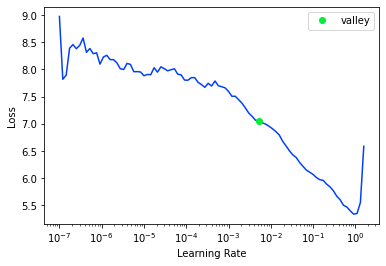

<Figure size 720x720 with 0 Axes>

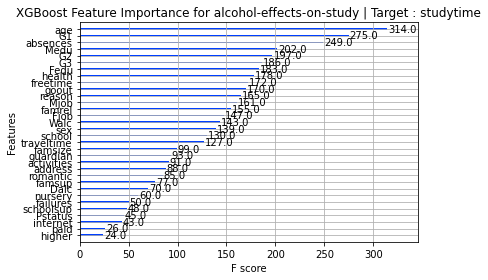

Target Variable: traveltime
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.10472962019683218, 'Adjusted R-Squared': -0.19369383973755694, 'RMSE': 0.7515918242585171, 'Time taken': 0.06685996055603027}


 12%|█▏        | 5/42 [00:00<00:01, 22.65it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.12083428571428567, 'Adjusted R-Squared': -0.17222095238095236, 'RMSE': 0.7448011024230178, 'Time taken': 0.04838418960571289}
{'Model': 'BayesianRidge', 'R-Squared': 0.1269852195327883, 'Adjusted R-Squared': -0.16401970728961546, 'RMSE': 0.7421910919868018, 'Time taken': 0.03780031204223633}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.806, 'Adjusted R-Squared': -1.408, 'RMSE': 1.0674899923282326, 'Time taken': 0.05442404747009277}
{'Model': 'DummyRegressor', 'R-Squared': -0.0004062679628065169, 'Adjusted R-Squared': -0.3338750239504087, 'RMSE': 0.7944986091857966, 'Time taken': 0.019666433334350586}
{'Model': 'ElasticNet', 'R-Squared': -0.0004062679628065169, 'Adjusted R-Squared': -0.3338750239504087, 'RMSE': 0.7944986091857966, 'Time taken': 0.033010005950927734}


 19%|█▉        | 8/42 [00:00<00:02, 14.97it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.14775020351845702, 'Adjusted R-Squared': -0.13633306197539063, 'RMSE': 0.7333113253272078, 'Time taken': 0.20213937759399414}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.6585714285714286, 'Adjusted R-Squared': -1.2114285714285713, 'RMSE': 1.0229915092057102, 'Time taken': 0.02675938606262207}


 24%|██▍       | 10/42 [00:00<00:03,  9.55it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.09517925714285702, 'Adjusted R-Squared': -0.20642765714285716, 'RMSE': 0.7555900204937646, 'Time taken': 0.3413960933685303}
{'Model': 'GammaRegressor', 'R-Squared': 0.1135460727818346, 'Adjusted R-Squared': -0.1819385696242204, 'RMSE': 0.7478819012707465, 'Time taken': 0.023258447647094727}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.946814479997782, 'Adjusted R-Squared': -5.595752639997042, 'RMSE': 1.7667201035483795, 'Time taken': 0.06975078582763672}


 29%|██▊       | 12/42 [00:01<00:03,  8.68it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.11013662967483362, 'Adjusted R-Squared': -0.18648449376688836, 'RMSE': 0.7493187575053709, 'Time taken': 0.20001721382141113}


 33%|███▎      | 14/42 [00:01<00:03,  7.37it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.003297733499984634, 'Adjusted R-Squared': -0.33773031133331277, 'RMSE': 0.795645946959624, 'Time taken': 0.2979600429534912}
{'Model': 'HuberRegressor', 'R-Squared': 0.08082100658652736, 'Adjusted R-Squared': -0.22557199121796345, 'RMSE': 0.7615615068927855, 'Time taken': 0.06257009506225586}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.026102857142857427, 'Adjusted R-Squared': -0.36813714285714316, 'RMSE': 0.8046377200113827, 'Time taken': 0.026057958602905273}
{'Model': 'KernelRidge', 'R-Squared': -4.1040116395955195, 'Adjusted R-Squared': -5.805348852794026, 'RMSE': 1.7945715039375287, 'Time taken': 0.05326437950134277}


 45%|████▌     | 19/42 [00:01<00:02, 10.30it/s]

{'Model': 'Lars', 'R-Squared': 0.1171422895119737, 'Adjusted R-Squared': -0.177143613984035, 'RMSE': 0.746363334628292, 'Time taken': 0.07496237754821777}
{'Model': 'LarsCV', 'R-Squared': 0.15020787964346438, 'Adjusted R-Squared': -0.13305616047538082, 'RMSE': 0.7322532183468485, 'Time taken': 0.11388826370239258}
{'Model': 'Lasso', 'R-Squared': -0.0004062679628065169, 'Adjusted R-Squared': -0.3338750239504087, 'RMSE': 0.7944986091857966, 'Time taken': 0.04801368713378906}


 55%|█████▍    | 23/42 [00:02<00:01,  9.93it/s]

{'Model': 'LassoCV', 'R-Squared': 0.14926158904284326, 'Adjusted R-Squared': -0.13431788127620892, 'RMSE': 0.732660807171293, 'Time taken': 0.23582816123962402}
{'Model': 'LassoLars', 'R-Squared': -0.0004062679628065169, 'Adjusted R-Squared': -0.3338750239504087, 'RMSE': 0.7944986091857966, 'Time taken': 0.03901195526123047}
{'Model': 'LassoLarsCV', 'R-Squared': 0.15020787964346438, 'Adjusted R-Squared': -0.13305616047538082, 'RMSE': 0.7322532183468485, 'Time taken': 0.10199761390686035}
{'Model': 'LassoLarsIC', 'R-Squared': 0.1477914857983441, 'Adjusted R-Squared': -0.13627801893554103, 'RMSE': 0.7332935646130913, 'Time taken': 0.046604156494140625}


 60%|█████▉    | 25/42 [00:02<00:01, 10.73it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.11714228951197392, 'Adjusted R-Squared': -0.17714361398403478, 'RMSE': 0.746363334628292, 'Time taken': 0.08817195892333984}
{'Model': 'LinearSVR', 'R-Squared': -0.06859376852035459, 'Adjusted R-Squared': -0.4247916913604728, 'RMSE': 0.8211287492830146, 'Time taken': 0.0564117431640625}


 64%|██████▍   | 27/42 [00:04<00:04,  3.12it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.2982269995143252, 'Adjusted R-Squared': -0.7309693326857669, 'RMSE': 0.9050660153889502, 'Time taken': 1.6377389430999756}
{'Model': 'NuSVR', 'R-Squared': 0.047036740098540086, 'Adjusted R-Squared': -0.27061767986861307, 'RMSE': 0.7754307478548853, 'Time taken': 0.09229683876037598}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.15612528069808573, 'Adjusted R-Squared': -0.12516629240255228, 'RMSE': 0.729699296421156, 'Time taken': 0.024783849716186523}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1514834175451898, 'Adjusted R-Squared': -0.13135544327308013, 'RMSE': 0.7317034559612435, 'Time taken': 0.03869175910949707}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.8708281591401095, 'Adjusted R-Squared': -1.494437545520146, 'RMSE': 1.0864803805264331, 'Time taken': 0.02920246124267578}


 74%|███████▍  | 31/42 [00:04<00:02,  5.27it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.12385461176291768, 'Adjusted R-Squared': -0.16819385098277628, 'RMSE': 0.7435206398748582, 'Time taken': 0.03865337371826172}
{'Model': 'QuantileRegressor', 'R-Squared': -0.5357142856600894, 'Adjusted R-Squared': -1.0476190475467857, 'RMSE': 0.9843740386803276, 'Time taken': 4.421184062957764}


 79%|███████▊  | 33/42 [00:08<00:06,  1.39it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.7716717734005933, 'Adjusted R-Squared': -2.6955623645341245, 'RMSE': 1.3224395792478179, 'Time taken': 0.2716858386993408}


 90%|█████████ | 38/42 [00:09<00:01,  2.53it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.1677755428571428, 'Adjusted R-Squared': -0.1096326095238096, 'RMSE': 0.7246447940331731, 'Time taken': 0.4039037227630615}
{'Model': 'Ridge', 'R-Squared': 0.11745171621574668, 'Adjusted R-Squared': -0.17673104504567094, 'RMSE': 0.7462325292998616, 'Time taken': 0.017200946807861328}
{'Model': 'RidgeCV', 'R-Squared': 0.11947154968188656, 'Adjusted R-Squared': -0.17403793375748444, 'RMSE': 0.7453781121260993, 'Time taken': 0.031216859817504883}
{'Model': 'SGDRegressor', 'R-Squared': 0.11351430133362639, 'Adjusted R-Squared': -0.18198093155516482, 'RMSE': 0.7478953035906296, 'Time taken': 0.0249176025390625}
{'Model': 'SVR', 'R-Squared': 0.002581080203560737, 'Adjusted R-Squared': -0.329891893061919, 'RMSE': 0.7933114822425412, 'Time taken': 0.07882428169250488}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.11714228951197392, 'Adjusted R-Squared': -0.17714361398403478, 'RMSE': 0.746363334628292, 'Time taken': 0.01890707015991211}


100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.05432644944853804, 'Adjusted R-Squared': -0.4057685992647173, 'RMSE': 0.81562865, 'Time taken': 0.6631097793579102}
{'Model': 'LGBMRegressor', 'R-Squared': 0.032068072287353755, 'Adjusted R-Squared': -0.2905759036168616, 'RMSE': 0.7814970572181611, 'Time taken': 0.0898137092590332}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: traveltime
traveltime
Target Standard Deviation: 0.7361241051785031
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                       -0.11       0.17  0.72        0.40
OrthogonalMatchingPursuit                   -0.13       0.16  0.73        0.02
OrthogonalMatchingPursuitCV                 -0.13       0.15  0.73        0.04
LarsCV                                      -0.13       0.15  0.73        0.11
LassoLarsCV                                 -0.13       0.15  0.73

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 1.6723687648773193.
Better model found at epoch 1 with _rmse value: 1.485780119895935.
Better model found at epoch 2 with _rmse value: 1.0804044008255005.
No improvement since epoch 2: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       1       1.32
1       2       1.75
2       2       1.91
3       2       1.28
4       2       1.83
XGBoost RMSE:  0.8151126


<Figure size 432x288 with 0 Axes>

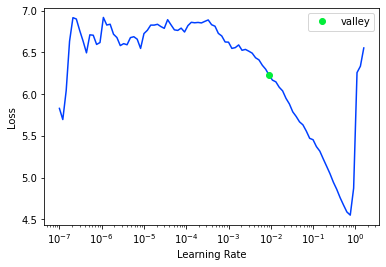

<Figure size 720x720 with 0 Axes>

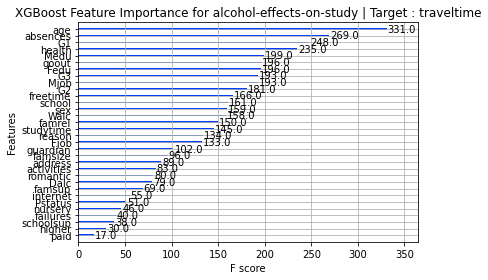

Target Variable: Fedu
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.36349110160270914, 'Adjusted R-Squared': 0.1513214688036122, 'RMSE': 0.8190818904076852, 'Time taken': 0.0699925422668457}


 14%|█▍        | 6/42 [00:00<00:01, 28.57it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.2788797035347774, 'Adjusted R-Squared': 0.038506271379703305, 'RMSE': 0.8718242479880018, 'Time taken': 0.04889106750488281}
{'Model': 'BayesianRidge', 'R-Squared': 0.3199877751304149, 'Adjusted R-Squared': 0.09331703350721987, 'RMSE': 0.8466100982073547, 'Time taken': 0.031139612197875977}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.22822120866590678, 'Adjusted R-Squared': -0.637628278221209, 'RMSE': 1.137793321922243, 'Time taken': 0.029392719268798828}
{'Model': 'DummyRegressor', 'R-Squared': -0.0001855108863597632, 'Adjusted R-Squared': -0.33358068118181294, 'RMSE': 1.02675154175618, 'Time taken': 0.0207517147064209}
{'Model': 'ElasticNet', 'R-Squared': 0.16443242402683433, 'Adjusted R-Squared': -0.11409010129755415, 'RMSE': 0.9384602317991044, 'Time taken': 0.022623062133789062}
{'Model': 'ElasticNetCV', 'R-Squared': 0.36573161928794284, 'Adjusted R-Squared': 0.15430882571725713, 'RMSE': 0.8176390313476767, 'Time taken': 0.208493

 21%|██▏       | 9/42 [00:00<00:03,  9.29it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.3698445610034208, 'Adjusted R-Squared': 0.1597927480045611, 'RMSE': 0.8149837112558772, 'Time taken': 0.3292708396911621}
{'Model': 'GammaRegressor', 'R-Squared': 0.29671198861524306, 'Adjusted R-Squared': 0.06228265148699075, 'RMSE': 0.8609772803461875, 'Time taken': 0.022267580032348633}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -10.354057847111264, 'Adjusted R-Squared': -14.13874379614835, 'RMSE': 3.4593988403215343, 'Time taken': 0.07256484031677246}


 29%|██▊       | 12/42 [00:01<00:03,  9.67it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.31229884678416864, 'Adjusted R-Squared': 0.08306512904555818, 'RMSE': 0.8513829732933648, 'Time taken': 0.1937258243560791}


 40%|████      | 17/42 [00:01<00:02, 11.26it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.2656308094585065, 'Adjusted R-Squared': 0.020841079278008712, 'RMSE': 0.8797966589240327, 'Time taken': 0.2819337844848633}
{'Model': 'HuberRegressor', 'R-Squared': 0.27691399214996915, 'Adjusted R-Squared': 0.0358853228666256, 'RMSE': 0.8730116979603003, 'Time taken': 0.052739620208740234}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.15627822120866575, 'Adjusted R-Squared': -0.12496237172177893, 'RMSE': 0.9430282740095312, 'Time taken': 0.024919748306274414}
{'Model': 'KernelRidge', 'R-Squared': -10.651562136826287, 'Adjusted R-Squared': -14.53541618243505, 'RMSE': 3.504428164280762, 'Time taken': 0.039925336837768555}
{'Model': 'Lars', 'R-Squared': 0.2925329011886054, 'Adjusted R-Squared': 0.0567105349181406, 'RMSE': 0.8635315468220841, 'Time taken': 0.03268146514892578}


 45%|████▌     | 19/42 [00:01<00:01, 12.10it/s]

{'Model': 'LarsCV', 'R-Squared': 0.36783317043362573, 'Adjusted R-Squared': 0.15711089391150102, 'RMSE': 0.8162833465951772, 'Time taken': 0.0998830795288086}
{'Model': 'Lasso', 'R-Squared': -0.0001855108863597632, 'Adjusted R-Squared': -0.33358068118181294, 'RMSE': 1.02675154175618, 'Time taken': 0.023723840713500977}


 50%|█████     | 21/42 [00:01<00:02, 10.13it/s]

{'Model': 'LassoCV', 'R-Squared': 0.36656219547719726, 'Adjusted R-Squared': 0.15541626063626302, 'RMSE': 0.8171035056918302, 'Time taken': 0.21851515769958496}
{'Model': 'LassoLars', 'R-Squared': -0.0001855108863597632, 'Adjusted R-Squared': -0.33358068118181294, 'RMSE': 1.02675154175618, 'Time taken': 0.05829143524169922}


 60%|█████▉    | 25/42 [00:02<00:01, 10.96it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.36783317043362573, 'Adjusted R-Squared': 0.15711089391150102, 'RMSE': 0.8162833465951772, 'Time taken': 0.14809608459472656}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3592953366946635, 'Adjusted R-Squared': 0.14572711559288476, 'RMSE': 0.8217770845738528, 'Time taken': 0.05400371551513672}
{'Model': 'LinearRegression', 'R-Squared': 0.29253290118860586, 'Adjusted R-Squared': 0.05671053491814115, 'RMSE': 0.8635315468220838, 'Time taken': 0.04937934875488281}
{'Model': 'LinearSVR', 'R-Squared': 0.09819695427326214, 'Adjusted R-Squared': -0.20240406096898367, 'RMSE': 0.9749468335084728, 'Time taken': 0.07250761985778809}


 64%|██████▍   | 27/42 [00:03<00:03,  4.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.22895996896163706, 'Adjusted R-Squared': -0.028053374717817103, 'RMSE': 0.9014954672898755, 'Time taken': 1.1811728477478027}
{'Model': 'NuSVR', 'R-Squared': 0.29567645673549237, 'Adjusted R-Squared': 0.06090194231398982, 'RMSE': 0.8616109051616534, 'Time taken': 0.07674503326416016}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.3746095421498883, 'Adjusted R-Squared': 0.16614605619985112, 'RMSE': 0.8118965752833615, 'Time taken': 0.02387690544128418}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.3499673703673847, 'Adjusted R-Squared': 0.13328982715651294, 'RMSE': 0.8277375608298572, 'Time taken': 0.03771567344665527}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.1702751162233438, 'Adjusted R-Squared': -0.5603668216311251, 'RMSE': 1.1106291540721296, 'Time taken': 0.026915311813354492}


 74%|███████▍  | 31/42 [00:03<00:01,  6.65it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.32250995211776246, 'Adjusted R-Squared': 0.09667993615701664, 'RMSE': 0.8450385939933677, 'Time taken': 0.035722970962524414}
{'Model': 'QuantileRegressor', 'R-Squared': -0.0958380843918456, 'Adjusted R-Squared': -0.46111744585579406, 'RMSE': 1.0747272955052003, 'Time taken': 4.457895994186401}


 79%|███████▊  | 33/42 [00:08<00:06,  1.44it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -0.9448216655334651, 'Adjusted R-Squared': -1.5930955540446199, 'RMSE': 1.4317426958129802, 'Time taken': 0.28911495208740234}


 88%|████████▊ | 37/42 [00:08<00:02,  2.33it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.3476306727480044, 'Adjusted R-Squared': 0.13017423033067255, 'RMSE': 0.8292239764386793, 'Time taken': 0.3987452983856201}
{'Model': 'Ridge', 'R-Squared': 0.2934658228050372, 'Adjusted R-Squared': 0.05795443040671633, 'RMSE': 0.8629619987771374, 'Time taken': 0.013623237609863281}
{'Model': 'RidgeCV', 'R-Squared': 0.3010894956909078, 'Adjusted R-Squared': 0.06811932758787709, 'RMSE': 0.8582935880426535, 'Time taken': 0.04079174995422363}
{'Model': 'SGDRegressor', 'R-Squared': 0.28590026200651464, 'Adjusted R-Squared': 0.04786701600868626, 'RMSE': 0.867569990204661, 'Time taken': 0.05845236778259277}
{'Model': 'SVR', 'R-Squared': 0.28400683360004586, 'Adjusted R-Squared': 0.04534244480006122, 'RMSE': 0.8687194054259244, 'Time taken': 0.05863595008850098}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.29253290118860586, 'Adjusted R-Squared': 0.05671053491814115, 'RMSE': 0.8635315468220838, 'Time taken': 0.017058849334716797}


 95%|█████████▌| 40/42 [00:09<00:00,  3.50it/s]

{'Model': 'TweedieRegressor', 'R-Squared': 0.3150401736598736, 'Adjusted R-Squared': 0.0867202315464981, 'RMSE': 0.8496843796962509, 'Time taken': 0.03225350379943848}


100%|██████████| 42/42 [00:09<00:00,  4.30it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.3344791224816519, 'Adjusted R-Squared': 0.11263882997553587, 'RMSE': 0.8375407, 'Time taken': 0.5707511901855469}
{'Model': 'LGBMRegressor', 'R-Squared': 0.26550019944771186, 'Adjusted R-Squared': 0.020666932596949183, 'RMSE': 0.879874892831283, 'Time taken': 0.08977508544921875}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: Fedu
Fedu
Target Standard Deviation: 1.1163059854961084
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuit                    0.17       0.37  0.81        0.02
ExtraTreesRegressor                          0.16       0.37  0.81        0.33
LassoLarsCV                                  0.16       0.37  0.82        0.15
LarsCV                                       0.16       0.37  0.82        0.10
LassoCV                                      0.16       0.37  0.82        0.22
El

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 4.311830520629883.
Better model found at epoch 1 with _rmse value: 3.3855361938476562.
Better model found at epoch 2 with _rmse value: 2.7943992614746094.
Better model found at epoch 3 with _rmse value: 2.1036746501922607.
Better model found at epoch 4 with _rmse value: 1.872963786125183.
Better model found at epoch 5 with _rmse value: 1.8503384590148926.
Better model found at epoch 6 with _rmse value: 1.795549988746643.
Better model found at epoch 7 with _rmse value: 1.6479823589324951.
Better model found at epoch 8 with _rmse value: 1.6322309970855713.
Better model found at epoch 9 with _rmse value: 1.5195425748825073.
Better model found at epoch 10 with _rmse value: 1.3702970743179321.
Better model found at epoch 11 with _rmse value: 1.1921652555465698.
No improvement since epoch 11: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.97
1       2       3.59
2       3       2.35
3       3       2.78
4       5       5.23
XGBoost RMSE:  0.83603424


<Figure size 432x288 with 0 Axes>

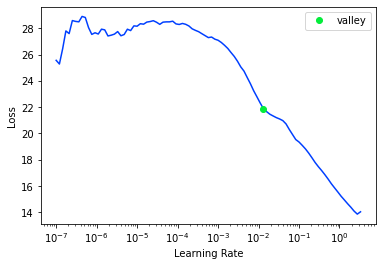

<Figure size 720x720 with 0 Axes>

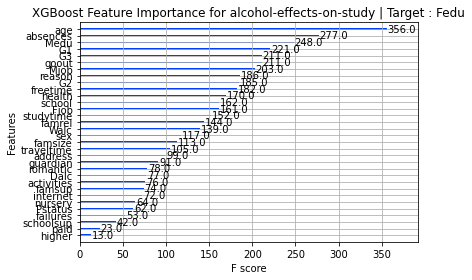

Target Variable: Medu
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 14.76it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.39768789544556093, 'Adjusted R-Squared': 0.19691719392741458, 'RMSE': 0.8591565250384523, 'Time taken': 0.13050556182861328}
{'Model': 'BaggingRegressor', 'R-Squared': 0.4942218299499852, 'Adjusted R-Squared': 0.32562910659998034, 'RMSE': 0.787302331534913, 'Time taken': 0.04873538017272949}
{'Model': 'BayesianRidge', 'R-Squared': 0.44382571262200277, 'Adjusted R-Squared': 0.2584342834960037, 'RMSE': 0.8255948034281476, 'Time taken': 0.039299726486206055}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.005736981465136903, 'Adjusted R-Squared': -0.3409826419535158, 'RMSE': 1.1102063499795358, 'Time taken': 0.06986618041992188}
{'Model': 'DummyRegressor', 'R-Squared': -0.0031170910866580304, 'Adjusted R-Squared': -0.3374894547822107, 'RMSE': 1.1087593933407973, 'Time taken': 0.02978992462158203}
{'Model': 'ElasticNet', 'R-Squared': 0.15833627713255372, 'Adjusted R-Squared': -0.12221829715659505, 'RMSE': 1.0156189639548074, 'Time taken': 0.

 17%|█▋        | 7/42 [00:00<00:03, 11.34it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.4582826220402231, 'Adjusted R-Squared': 0.27771016272029747, 'RMSE': 0.8147941102558038, 'Time taken': 0.25397229194641113}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.13342159458664304, 'Adjusted R-Squared': -0.15543787388447594, 'RMSE': 1.0305413644662542, 'Time taken': 0.05520772933959961}


 21%|██▏       | 9/42 [00:00<00:04,  8.07it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.4541289791115033, 'Adjusted R-Squared': 0.27217197214867106, 'RMSE': 0.817911880926815, 'Time taken': 0.3261082172393799}
{'Model': 'GammaRegressor', 'R-Squared': 0.4265356353620382, 'Adjusted R-Squared': 0.23538084714938434, 'RMSE': 0.8383294348627428, 'Time taken': 0.022164106369018555}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -9.771864867614259, 'Adjusted R-Squared': -13.362486490152344, 'RMSE': 3.633347574494769, 'Time taken': 0.06598424911499023}


 29%|██▊       | 12/42 [00:01<00:03,  9.01it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5113401288223169, 'Adjusted R-Squared': 0.3484535050964226, 'RMSE': 0.7738643411065351, 'Time taken': 0.18909335136413574}


 38%|███▊      | 16/42 [00:01<00:02, 10.20it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.47435676957383255, 'Adjusted R-Squared': 0.2991423594317768, 'RMSE': 0.8026145620950429, 'Time taken': 0.2822599411010742}
{'Model': 'HuberRegressor', 'R-Squared': 0.4160081747497809, 'Adjusted R-Squared': 0.22134423299970796, 'RMSE': 0.8459893213653756, 'Time taken': 0.05111980438232422}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.33279788172992053, 'Adjusted R-Squared': 0.11039717563989404, 'RMSE': 0.9042535145658275, 'Time taken': 0.025731563568115234}
{'Model': 'KernelRidge', 'R-Squared': -9.661198320250355, 'Adjusted R-Squared': -13.21493109366714, 'RMSE': 3.614635489335144, 'Time taken': 0.03811311721801758}
{'Model': 'Lars', 'R-Squared': 0.43687157689852296, 'Adjusted R-Squared': 0.24916210253136395, 'RMSE': 0.830740189655263, 'Time taken': 0.06434273719787598}


 43%|████▎     | 18/42 [00:01<00:02,  9.32it/s]

{'Model': 'LarsCV', 'R-Squared': 0.46213785400762597, 'Adjusted R-Squared': 0.282850472010168, 'RMSE': 0.8118896169043952, 'Time taken': 0.18452763557434082}
{'Model': 'Lasso', 'R-Squared': -0.0031170910866580304, 'Adjusted R-Squared': -0.3374894547822107, 'RMSE': 1.1087593933407973, 'Time taken': 0.02746272087097168}


 52%|█████▏    | 22/42 [00:02<00:01, 10.42it/s]

{'Model': 'LassoCV', 'R-Squared': 0.46064962715779045, 'Adjusted R-Squared': 0.2808661695437207, 'RMSE': 0.8130120618343746, 'Time taken': 0.20070791244506836}
{'Model': 'LassoLars', 'R-Squared': -0.0031170910866580304, 'Adjusted R-Squared': -0.3374894547822107, 'RMSE': 1.1087593933407973, 'Time taken': 0.019855022430419922}
{'Model': 'LassoLarsCV', 'R-Squared': 0.46213785400762597, 'Adjusted R-Squared': 0.282850472010168, 'RMSE': 0.8118896169043952, 'Time taken': 0.10029196739196777}
{'Model': 'LassoLarsIC', 'R-Squared': 0.45417193739875705, 'Adjusted R-Squared': 0.2722292498650094, 'RMSE': 0.8178796967812145, 'Time taken': 0.05362391471862793}


 60%|█████▉    | 25/42 [00:02<00:01, 13.10it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.43687157689852296, 'Adjusted R-Squared': 0.24916210253136395, 'RMSE': 0.8307401896552629, 'Time taken': 0.025018930435180664}
{'Model': 'LinearSVR', 'R-Squared': 0.40921430562323, 'Adjusted R-Squared': 0.2122857408309734, 'RMSE': 0.8508960007153649, 'Time taken': 0.05360746383666992}


 64%|██████▍   | 27/42 [00:03<00:03,  4.35it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.2639609575963353, 'Adjusted R-Squared': 0.018614610128447118, 'RMSE': 0.9497557313375905, 'Time taken': 1.2112743854522705}
{'Model': 'NuSVR', 'R-Squared': 0.45275184860007467, 'Adjusted R-Squared': 0.2703357981334329, 'RMSE': 0.8189429504033038, 'Time taken': 0.08445501327514648}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.438814691406071, 'Adjusted R-Squared': 0.2517529218747614, 'RMSE': 0.8293056871920035, 'Time taken': 0.024570465087890625}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.4613953475338669, 'Adjusted R-Squared': 0.28186046337848925, 'RMSE': 0.8124498212198333, 'Time taken': 0.03867959976196289}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.000629331249368148, 'Adjusted R-Squared': -0.33249422500084247, 'RMSE': 1.1066869699360065, 'Time taken': 0.025260210037231445}


 74%|███████▍  | 31/42 [00:03<00:01,  6.96it/s]

{'Model': 'PoissonRegressor', 'R-Squared': 0.46464913017809295, 'Adjusted R-Squared': 0.28619884023745734, 'RMSE': 0.8099920447153364, 'Time taken': 0.03309011459350586}
{'Model': 'QuantileRegressor', 'R-Squared': -0.1765224852793843, 'Adjusted R-Squared': -0.568696647039179, 'RMSE': 1.2007749326844182, 'Time taken': 5.100717306137085}


 79%|███████▊  | 33/42 [00:09<00:06,  1.34it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.2543052114968898, 'Adjusted R-Squared': -2.0057402819958527, 'RMSE': 1.662140970679059, 'Time taken': 0.27916574478149414}


 90%|█████████ | 38/42 [00:09<00:01,  2.42it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5196214327743454, 'Adjusted R-Squared': 0.3594952436991272, 'RMSE': 0.7672789937588321, 'Time taken': 0.4077723026275635}
{'Model': 'Ridge', 'R-Squared': 0.43711253624634094, 'Adjusted R-Squared': 0.24948338166178796, 'RMSE': 0.8305624362121219, 'Time taken': 0.016307592391967773}
{'Model': 'RidgeCV', 'R-Squared': 0.4391114177617864, 'Adjusted R-Squared': 0.25214855701571526, 'RMSE': 0.829086410789529, 'Time taken': 0.0301666259765625}
{'Model': 'SGDRegressor', 'R-Squared': 0.4347283061960888, 'Adjusted R-Squared': 0.24630440826145183, 'RMSE': 0.832319589755903, 'Time taken': 0.02390313148498535}
{'Model': 'SVR', 'R-Squared': 0.4620498293887957, 'Adjusted R-Squared': 0.2827331058517276, 'RMSE': 0.8119560496798308, 'Time taken': 0.08775782585144043}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.43687157689852296, 'Adjusted R-Squared': 0.24916210253136395, 'RMSE': 0.8307401896552629, 'Time taken': 0.01816248893737793}
{'Model': '

100%|██████████| 42/42 [00:10<00:00,  3.98it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.41270427013855304, 'Adjusted R-Squared': 0.2169390268514041, 'RMSE': 0.84837896, 'Time taken': 0.5810110569000244}
{'Model': 'LGBMRegressor', 'R-Squared': 0.47056092127724314, 'Adjusted R-Squared': 0.29408122836965755, 'RMSE': 0.8055073252596319, 'Time taken': 0.08481073379516602}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: Medu
Medu
Target Standard Deviation: 1.1398575121167531
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                        0.36       0.52  0.77        0.41
GradientBoostingRegressor                    0.35       0.51  0.77        0.19
BaggingRegressor                             0.33       0.49  0.79        0.05
HistGradientBoostingRegressor                0.30       0.47  0.80        0.28
LGBMRegressor                                0.29       0.47  0.81        0.08
P

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 3.257179021835327.
Better model found at epoch 1 with _rmse value: 2.4005239009857178.
Better model found at epoch 2 with _rmse value: 1.9511091709136963.
Better model found at epoch 3 with _rmse value: 1.6513780355453491.
Better model found at epoch 4 with _rmse value: 1.3066604137420654.
No improvement since epoch 4: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       3.83
1       5       4.77
2       4       2.71
3       5       4.59
4       2       2.93
XGBoost RMSE:  0.8413128


<Figure size 432x288 with 0 Axes>

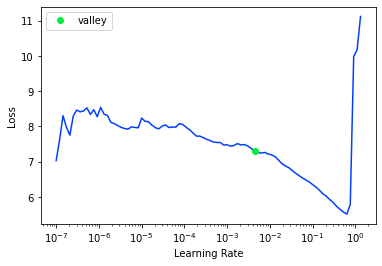

<Figure size 720x720 with 0 Axes>

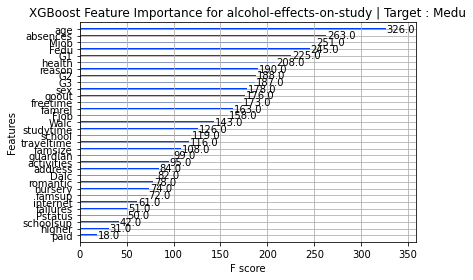

Target Variable: age
CATS=====================
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
CONTS=====================
[]
33
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : []
Categorical variables that made the cut : ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
Tabular Object size: 649


 10%|▉         | 4/42 [00:00<00:02, 17.17it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.14419954654519507, 'Adjusted R-Squared': -0.14106727127307317, 'RMSE': 1.2068218658090053, 'Time taken': 0.12944817543029785}
{'Model': 'BaggingRegressor', 'R-Squared': 0.12455826271186454, 'Adjusted R-Squared': -0.16725564971751394, 'RMSE': 1.220592053570852, 'Time taken': 0.05265545845031738}
{'Model': 'BayesianRidge', 'R-Squared': 0.1634346955126067, 'Adjusted R-Squared': -0.11542040598319092, 'RMSE': 1.1931823997667805, 'Time taken': 0.03474998474121094}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.894915254237288, 'Adjusted R-Squared': -1.5265536723163837, 'RMSE': 1.7957745408459236, 'Time taken': 0.0360407829284668}
{'Model': 'DummyRegressor', 'R-Squared': -0.004450699215224008, 'Adjusted R-Squared': -0.339267598953632, 'RMSE': 1.307438371991278, 'Time taken': 0.02093648910522461}
{'Model': 'ElasticNet', 'R-Squared': -0.004450699215224008, 'Adjusted R-Squared': -0.339267598953632, 'RMSE': 1.307438371991278, 'Time taken': 0.03761

 17%|█▋        | 7/42 [00:00<00:02, 12.73it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.18467775069968684, 'Adjusted R-Squared': -0.08709633240041748, 'RMSE': 1.177935637398966, 'Time taken': 0.22715330123901367}
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.658050847457627, 'Adjusted R-Squared': -1.210734463276836, 'RMSE': 1.6797932689341832, 'Time taken': 0.027592897415161133}


 21%|██▏       | 9/42 [00:00<00:04,  7.94it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.07906162076271195, 'Adjusted R-Squared': -0.22791783898305074, 'RMSE': 1.2519073819669153, 'Time taken': 0.40357303619384766}
{'Model': 'GammaRegressor', 'R-Squared': 0.11222843902143531, 'Adjusted R-Squared': -0.18369541463808625, 'RMSE': 1.2291574804339782, 'Time taken': 0.02459120750427246}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -4.629975591529977, 'Adjusted R-Squared': -6.506634122039969, 'RMSE': 3.0953529019956827, 'Time taken': 0.06861543655395508}


 29%|██▊       | 12/42 [00:01<00:03,  8.76it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.0505423173360936, 'Adjusted R-Squared': -0.26594357688520853, 'RMSE': 1.2711439088125913, 'Time taken': 0.19916629791259766}


 33%|███▎      | 14/42 [00:01<00:03,  7.76it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -9.489837928344791e-05, 'Adjusted R-Squared': -0.3334598645057112, 'RMSE': 1.3046004384769894, 'Time taken': 0.2790253162384033}
{'Model': 'HuberRegressor', 'R-Squared': 0.1793140952535206, 'Adjusted R-Squared': -0.09424787299530579, 'RMSE': 1.1818038527092753, 'Time taken': 0.05027270317077637}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.04420762711864401, 'Adjusted R-Squared': -0.39227683615819187, 'RMSE': 1.3330619878932455, 'Time taken': 0.02550959587097168}
{'Model': 'KernelRidge', 'R-Squared': -4.326043402224379, 'Adjusted R-Squared': -6.101391202965839, 'RMSE': 3.010643031831563, 'Time taken': 0.05085873603820801}
{'Model': 'Lars', 'R-Squared': 0.18832025986253165, 'Adjusted R-Squared': -0.08223965351662432, 'RMSE': 1.175301437071477, 'Time taken': 0.06387948989868164}


 45%|████▌     | 19/42 [00:01<00:02,  9.61it/s]

{'Model': 'LarsCV', 'R-Squared': 0.18445676212091022, 'Adjusted R-Squared': -0.0873909838387863, 'RMSE': 1.1780952630476558, 'Time taken': 0.1620774269104004}
{'Model': 'Lasso', 'R-Squared': -0.004450699215224008, 'Adjusted R-Squared': -0.339267598953632, 'RMSE': 1.307438371991278, 'Time taken': 0.05992841720581055}


 50%|█████     | 21/42 [00:02<00:02,  7.95it/s]

{'Model': 'LassoCV', 'R-Squared': 0.18823628584793128, 'Adjusted R-Squared': -0.08235161886942488, 'RMSE': 1.175362232125622, 'Time taken': 0.28299760818481445}
{'Model': 'LassoLars', 'R-Squared': -0.004450699215224008, 'Adjusted R-Squared': -0.339267598953632, 'RMSE': 1.307438371991278, 'Time taken': 0.06769824028015137}


 55%|█████▍    | 23/42 [00:02<00:02,  7.90it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.18445676212091022, 'Adjusted R-Squared': -0.0873909838387863, 'RMSE': 1.1780952630476558, 'Time taken': 0.1516742706298828}
{'Model': 'LassoLarsIC', 'R-Squared': 0.19220275927161834, 'Adjusted R-Squared': -0.07706298763784214, 'RMSE': 1.172487163987832, 'Time taken': 0.10418486595153809}
{'Model': 'LinearRegression', 'R-Squared': 0.1883202598625322, 'Adjusted R-Squared': -0.08223965351662366, 'RMSE': 1.1753014370714767, 'Time taken': 0.07758545875549316}


 60%|█████▉    | 25/42 [00:02<00:01,  8.66it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.17112986079288084, 'Adjusted R-Squared': -0.10516018560949214, 'RMSE': 1.1876819636370377, 'Time taken': 0.10866403579711914}


 69%|██████▉   | 29/42 [00:04<00:03,  4.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.1459833689389174, 'Adjusted R-Squared': -0.5279778252518899, 'RMSE': 1.3965165012781107, 'Time taken': 1.549529790878296}
{'Model': 'NuSVR', 'R-Squared': 0.09681089462411996, 'Adjusted R-Squared': -0.20425214050117324, 'RMSE': 1.2397846625560989, 'Time taken': 0.07295441627502441}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.16587680203612454, 'Adjusted R-Squared': -0.11216426395183388, 'RMSE': 1.191439554247639, 'Time taken': 0.024062156677246094}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.16800428936446488, 'Adjusted R-Squared': -0.10932761418071335, 'RMSE': 1.189919160796277, 'Time taken': 0.0385279655456543}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.5893604572700095, 'Adjusted R-Squared': -1.1191472763600125, 'RMSE': 1.6446296517142693, 'Time taken': 0.026696205139160156}
{'Model': 'PoissonRegressor', 'R-Squared': 0.14775265708160046, 'Adjusted R-Squared': -0.13632979055786598, 'RMSE': 1.20431401983238, '

 76%|███████▌  | 32/42 [00:09<00:07,  1.32it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.020338983061796156, 'Adjusted R-Squared': -0.3604519774157282, 'RMSE': 1.3177382549451027, 'Time taken': 4.548778533935547}


 79%|███████▊  | 33/42 [00:09<00:06,  1.47it/s]

{'Model': 'RANSACRegressor', 'R-Squared': -1.3014072095324947, 'Adjusted R-Squared': -2.0685429460433262, 'RMSE': 1.9790357924367976, 'Time taken': 0.2788734436035156}


 88%|████████▊ | 37/42 [00:09<00:01,  2.70it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.13713120762711872, 'Adjusted R-Squared': -0.15049172316384163, 'RMSE': 1.211795387850401, 'Time taken': 0.4355592727661133}
{'Model': 'Ridge', 'R-Squared': 0.18798638378644184, 'Adjusted R-Squared': -0.08268482161807755, 'RMSE': 1.1755431362712894, 'Time taken': 0.01699042320251465}
{'Model': 'RidgeCV', 'R-Squared': 0.1850109555241457, 'Adjusted R-Squared': -0.08665205930113906, 'RMSE': 1.1776949142083608, 'Time taken': 0.04120969772338867}
{'Model': 'SGDRegressor', 'R-Squared': 0.18071825690829135, 'Adjusted R-Squared': -0.09237565745561138, 'RMSE': 1.1807924096818057, 'Time taken': 0.05230069160461426}
{'Model': 'SVR', 'R-Squared': 0.05844728430993029, 'Adjusted R-Squared': -0.25540362092009294, 'RMSE': 1.265841222136506, 'Time taken': 0.0715951919555664}


 95%|█████████▌| 40/42 [00:10<00:00,  4.12it/s]

{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.1883202598625322, 'Adjusted R-Squared': -0.08223965351662366, 'RMSE': 1.1753014370714767, 'Time taken': 0.01900649070739746}
{'Model': 'TweedieRegressor', 'R-Squared': 0.12496410706017502, 'Adjusted R-Squared': -0.1667145239197665, 'RMSE': 1.2203090948137498, 'Time taken': 0.026059865951538086}


100%|██████████| 42/42 [00:10<00:00,  3.91it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.05797205827808305, 'Adjusted R-Squared': -0.2560372556292225, 'RMSE': 1.2661606, 'Time taken': 0.5816411972045898}
{'Model': 'LGBMRegressor', 'R-Squared': 0.0026877359472664564, 'Adjusted R-Squared': -0.3297496854036446, 'RMSE': 1.302784233511981, 'Time taken': 0.09720730781555176}
Project: alcohol-effects-on-study
alcohol-effects-on-study
Target: age
age
Target Standard Deviation: 1.1939133109580613
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LassoLarsIC                                 -0.08       0.19  1.17        0.10
LinearRegression                            -0.08       0.19  1.18        0.08
TransformedTargetRegressor                  -0.08       0.19  1.18        0.02
Lars                                        -0.08       0.19  1.18        0.06
LassoCV                                     -0.08       0.19  1.18        0.28
Ri

LEARNING RATE: 0.1


Better model found at epoch 0 with _rmse value: 2.06500506401062.
Better model found at epoch 1 with _rmse value: 1.2830623388290405.
No improvement since epoch 1: early stopping


Could not show results
XGBoost Predictions vs Actual==========
   actual  predicted
0       3       2.29
1       3       1.94
2       1       2.15
3       1       2.49
4       2       1.94
XGBoost RMSE:  1.2659118


<Figure size 432x288 with 0 Axes>

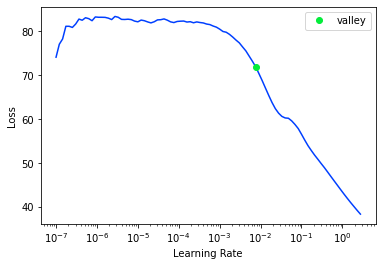

<Figure size 720x720 with 0 Axes>

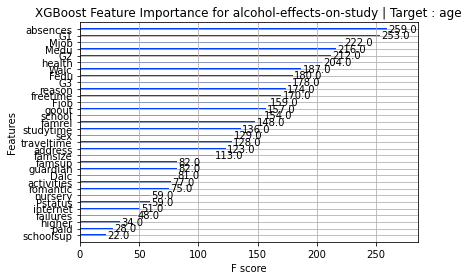

<Figure size 432x288 with 0 Axes>

In [19]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

   feature  importance
0   school      152.00
1      sex      142.00
2      age      323.00
3  address       90.00
4  famsize      114.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

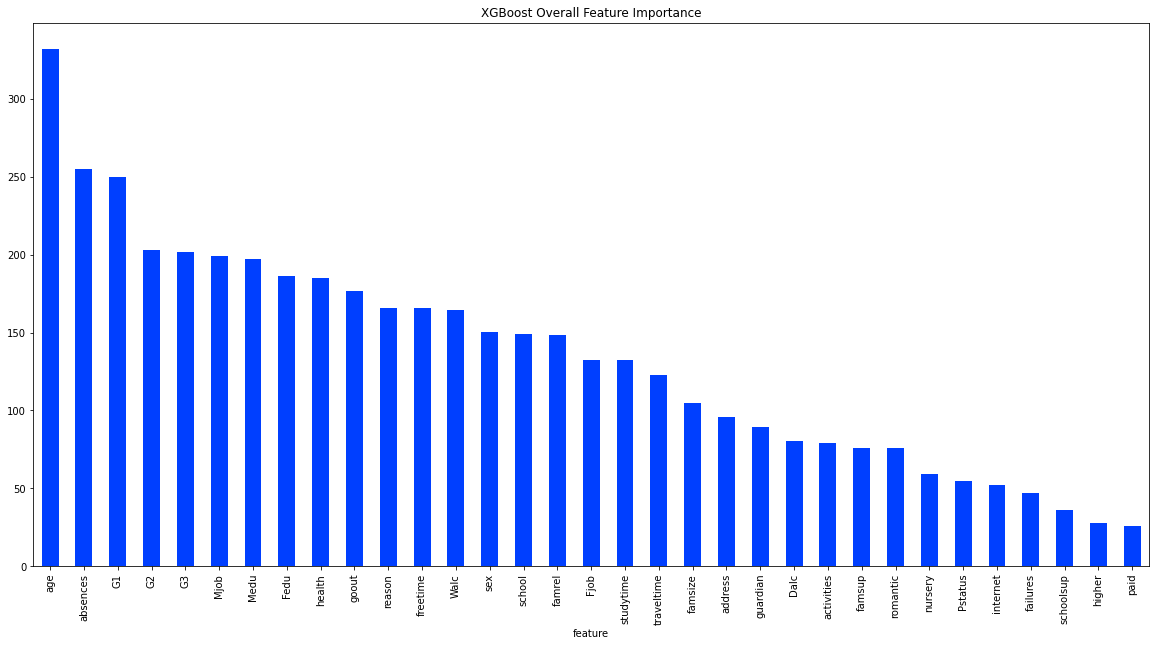

In [20]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [21]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

# **To Be Continued...**